Experiment 1

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k


2025-08-01 11:58:50.647790: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 11:58:50.671403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754067530.687388  158680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754067530.692573  158680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 11:58:50.712938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)
categories =dict(enumerate(info.features["label"].names))
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

max_tokens = None
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)


doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = text_vectorization(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

I0000 00:00:1754067532.911062  158680 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5207 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-08-01 11:58:54.959252: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-08-01 11:59:02.609247: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-01 12:10:37.746420: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.


In [4]:
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

There are 95827 vocabulary words in the corpus.


In [5]:
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:50])

['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


In [6]:
tfds.as_dataframe(dataset_all.take(10),info)

2025-08-01 12:22:33.880018: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


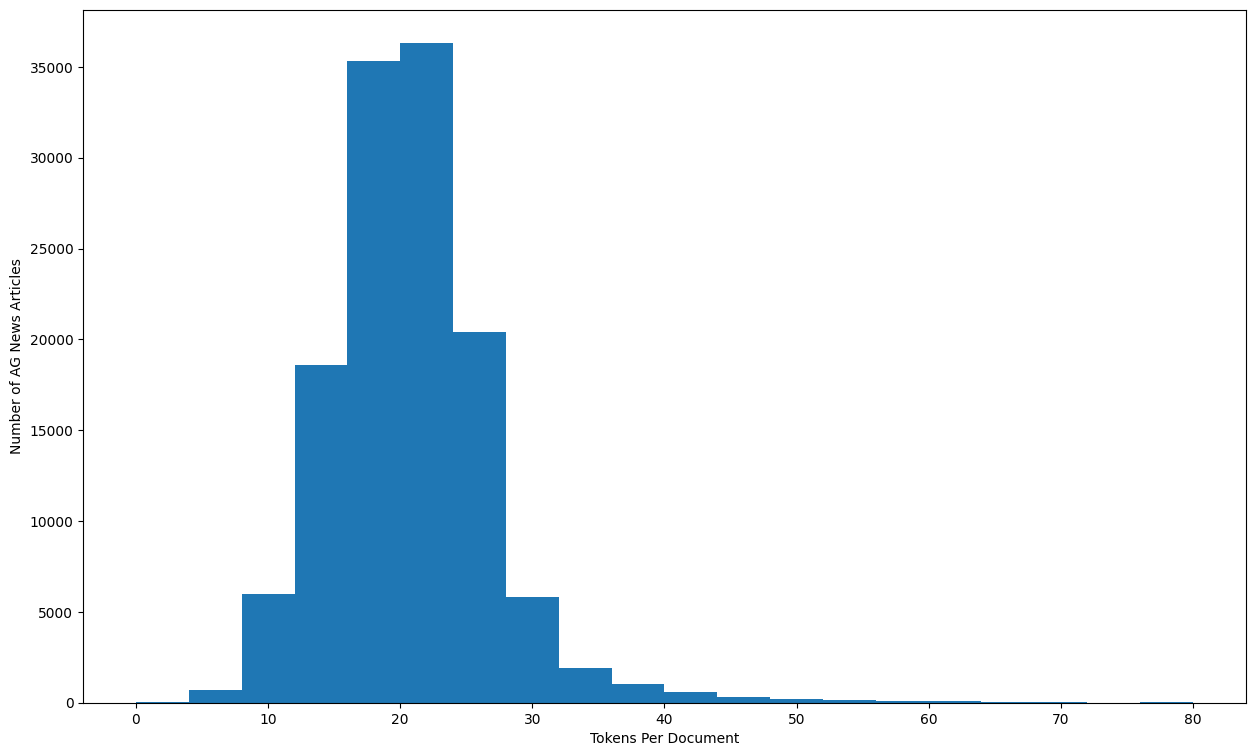

In [7]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,80))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

In [8]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)

Last Run: 2025-08-01 12:22:34


After testing multiple preprocessing configurations, I evaluated three vocabulary sizes (10,000 tokens, 20,000 tokens, and full vocabulary), two standardization methods (custom stopword removal and lower-and-strip-punctuation), and three sequence lengths (64, 128, and 256 tokens). The best results were achieved using the full vocabulary with custom stopword removal and no fixed sequence length. Using the full vocabulary preserved rare but meaningful words that added context, while removing stopwords reduced noise and focused the input on more informative tokens. Allowing variable sequence lengths avoided unnecessary truncation or padding, which maintained the natural flow of text and reduced computational overhead. This combination provided the cleanest and most context-rich input for the models and will be used in subsequent experiments.

In [9]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

Experiment 2- RNN baseline 64 units 

Epoch 1/10


I0000 00:00:1754069612.453067  158775 service.cc:148] XLA service 0x7faa80006090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754069612.453224  158775 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-08-01 12:33:32.492369: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754069612.576574  158775 cuda_dnn.cc:529] Loaded cuDNN version 90501


   2/1200 ━━━━━━━━━━━━━━━━━━━━ 1:27 73ms/step - accuracy: 0.2900 - loss: 1.3914

I0000 00:00:1754069614.098125  158775 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7894 - loss: 0.5518 - val_accuracy: 0.9011 - val_loss: 0.2995
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9400 - loss: 0.1874 - val_accuracy: 0.8909 - val_loss: 0.3463
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9725 - loss: 0.0902 - val_accuracy: 0.8846 - val_loss: 0.4305
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9838 - loss: 0.0523 - val_accuracy: 0.8855 - val_loss: 0.5069
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9885 - loss: 0.0368 - val_accuracy: 0.8701 - val_loss: 0.6060
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9912 - loss: 0.0278 - val_accuracy: 0.8736 - val_loss: 0.6173
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9925 - loss: 0.0228 - val_accuracy: 0.8704 - val_loss: 0.6089
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9942 - loss: 0.01

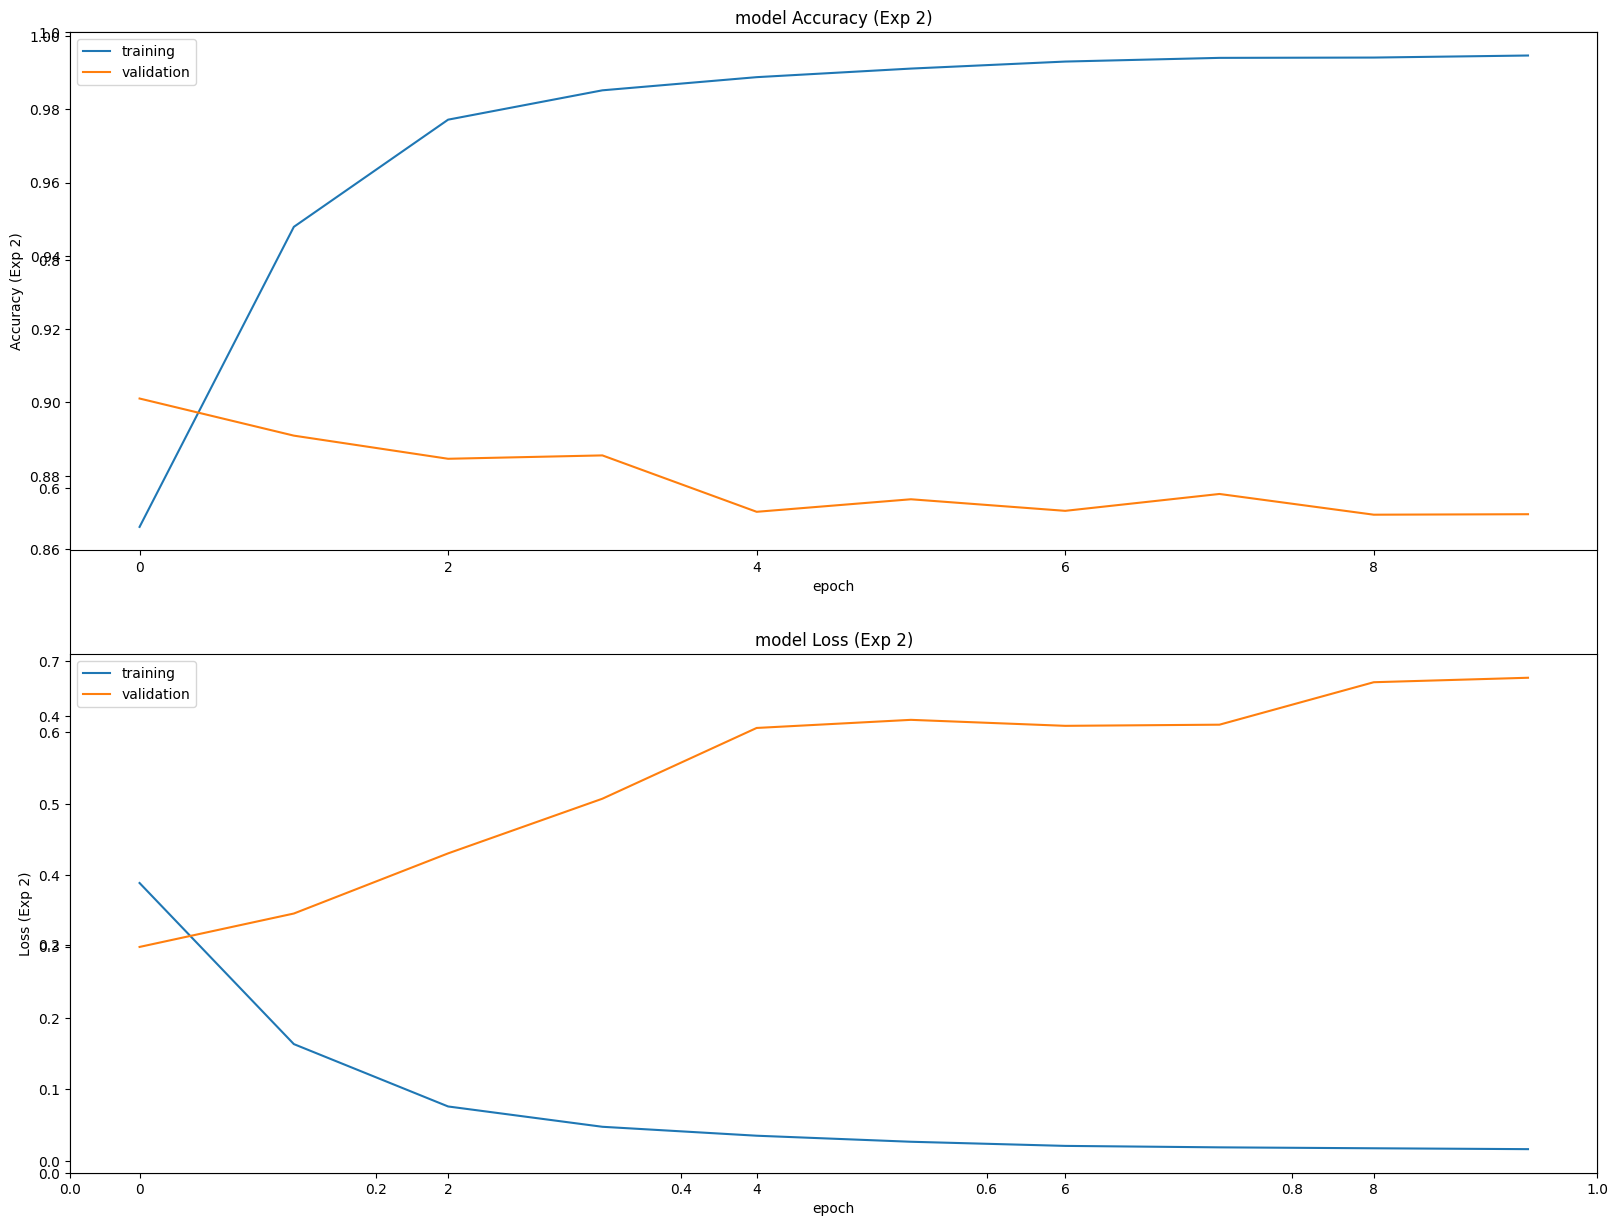

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1900
           1       0.95      0.95      0.95      1900
           2       0.85      0.79      0.82      1900
           3       0.83      0.83      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8694736842105263
Root Mean Square Error: 0.6454292737151152


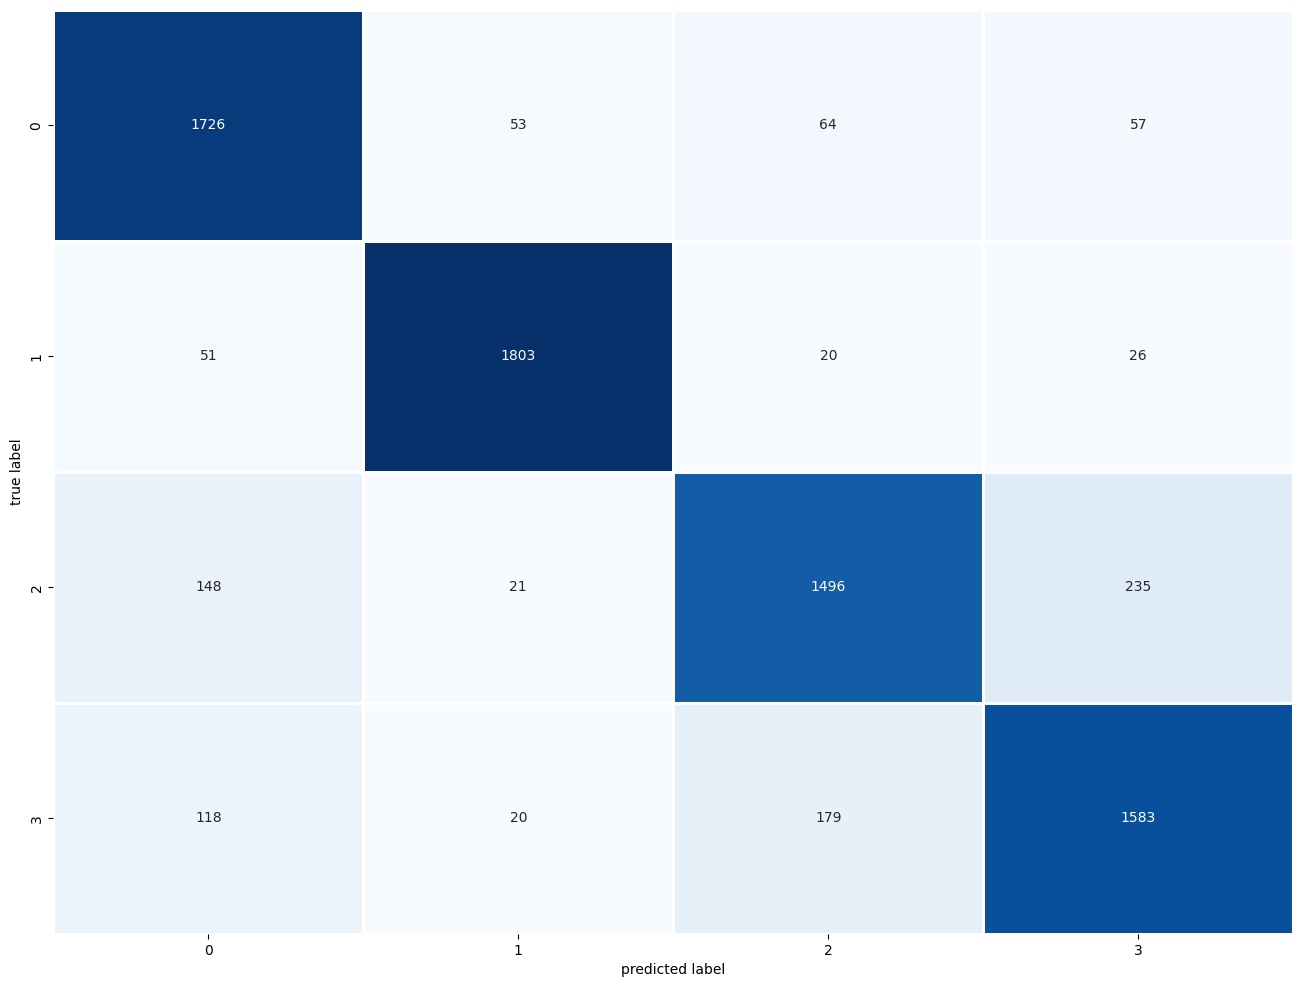

In [10]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk, re, string
from nltk.corpus import stopwords
from collections import Counter

# ======================
# 1. Load Dataset
# ======================
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True, split=ri, as_supervised=True)

train_ds, test_ds = tfds.load('ag_news_subset', split=['train', 'test'], as_supervised=True)
n_classes = info.features['label'].num_classes

# ======================
# 2. Preprocessing Functions
# ======================
nltk.download('stopwords', quiet=True)
STOPWORDS = stopwords.words("english")

def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*', "")

# Text Vectorization (from EDA findings)
text_vectorization = layers.TextVectorization(
    max_tokens=None,   # Full vocabulary
    output_mode='int',
    output_sequence_length=128,
    standardize=custom_stopwords  # Using stopword removal
)
text_only_train = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train)

# ======================
# 3. Prepare Dataset for Model
# ======================
batch_size = 100
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds):
    return ds.map(lambda x, y: (text_vectorization(x), y)).batch(batch_size).prefetch(AUTOTUNE)

int_train_ds = prepare_dataset(train_ds)
int_test_ds = prepare_dataset(test_ds)

# ======================
# Experiment 2: Baseline RNN (SimpleRNN - 64 units)
# ======================
import time
start_time = time.time()

model2 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.SimpleRNN(64),
    layers.Dense(n_classes, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime2 = end_time - start_time

# Metrics & Visualization
history_df2 = pd.DataFrame(history2.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df2['accuracy'], history_df2['val_accuracy'], 'Accuracy (Exp 2)', 211)
display_training_curves(history_df2['loss'], history_df2['val_loss'], 'Loss (Exp 2)', 212)
plt.show()

y_test2 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes2 = np.argmax(model2.predict(int_test_ds), axis=-1)
print_validation_report(y_test2, pred_classes2)
plot_confusion_matrix(y_test2, pred_classes2)

Experiment 3 - RNN - 128 units

Epoch 1/10


2025-08-01 12:40:06.302548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 36 bytes spill stores, 36 bytes spill loads

2025-08-01 12:40:06.368615: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 60 bytes spill stores, 60 bytes spill loads

2025-08-01 12:40:06.482291: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 40 bytes spill stores, 40 bytes spill loads

2025-08-01 12:40:06.491618: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 20 bytes spill stores, 24 bytes spill loads



1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7969 - loss: 0.5299 - val_accuracy: 0.8979 - val_loss: 0.3171
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9396 - loss: 0.1886 - val_accuracy: 0.8893 - val_loss: 0.3501
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9715 - loss: 0.0904 - val_accuracy: 0.8809 - val_loss: 0.4879
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9837 - loss: 0.0507 - val_accuracy: 0.8636 - val_loss: 0.5972
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9872 - loss: 0.0401 - val_accuracy: 0.8805 - val_loss: 0.5958
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.9896 - loss: 0.0332 - val_accuracy: 0.8707 - val_loss: 0.6357
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9915 - loss: 0.0260 - val_accuracy: 0.8736 - val_loss: 0.6607
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9926 - loss: 0.02

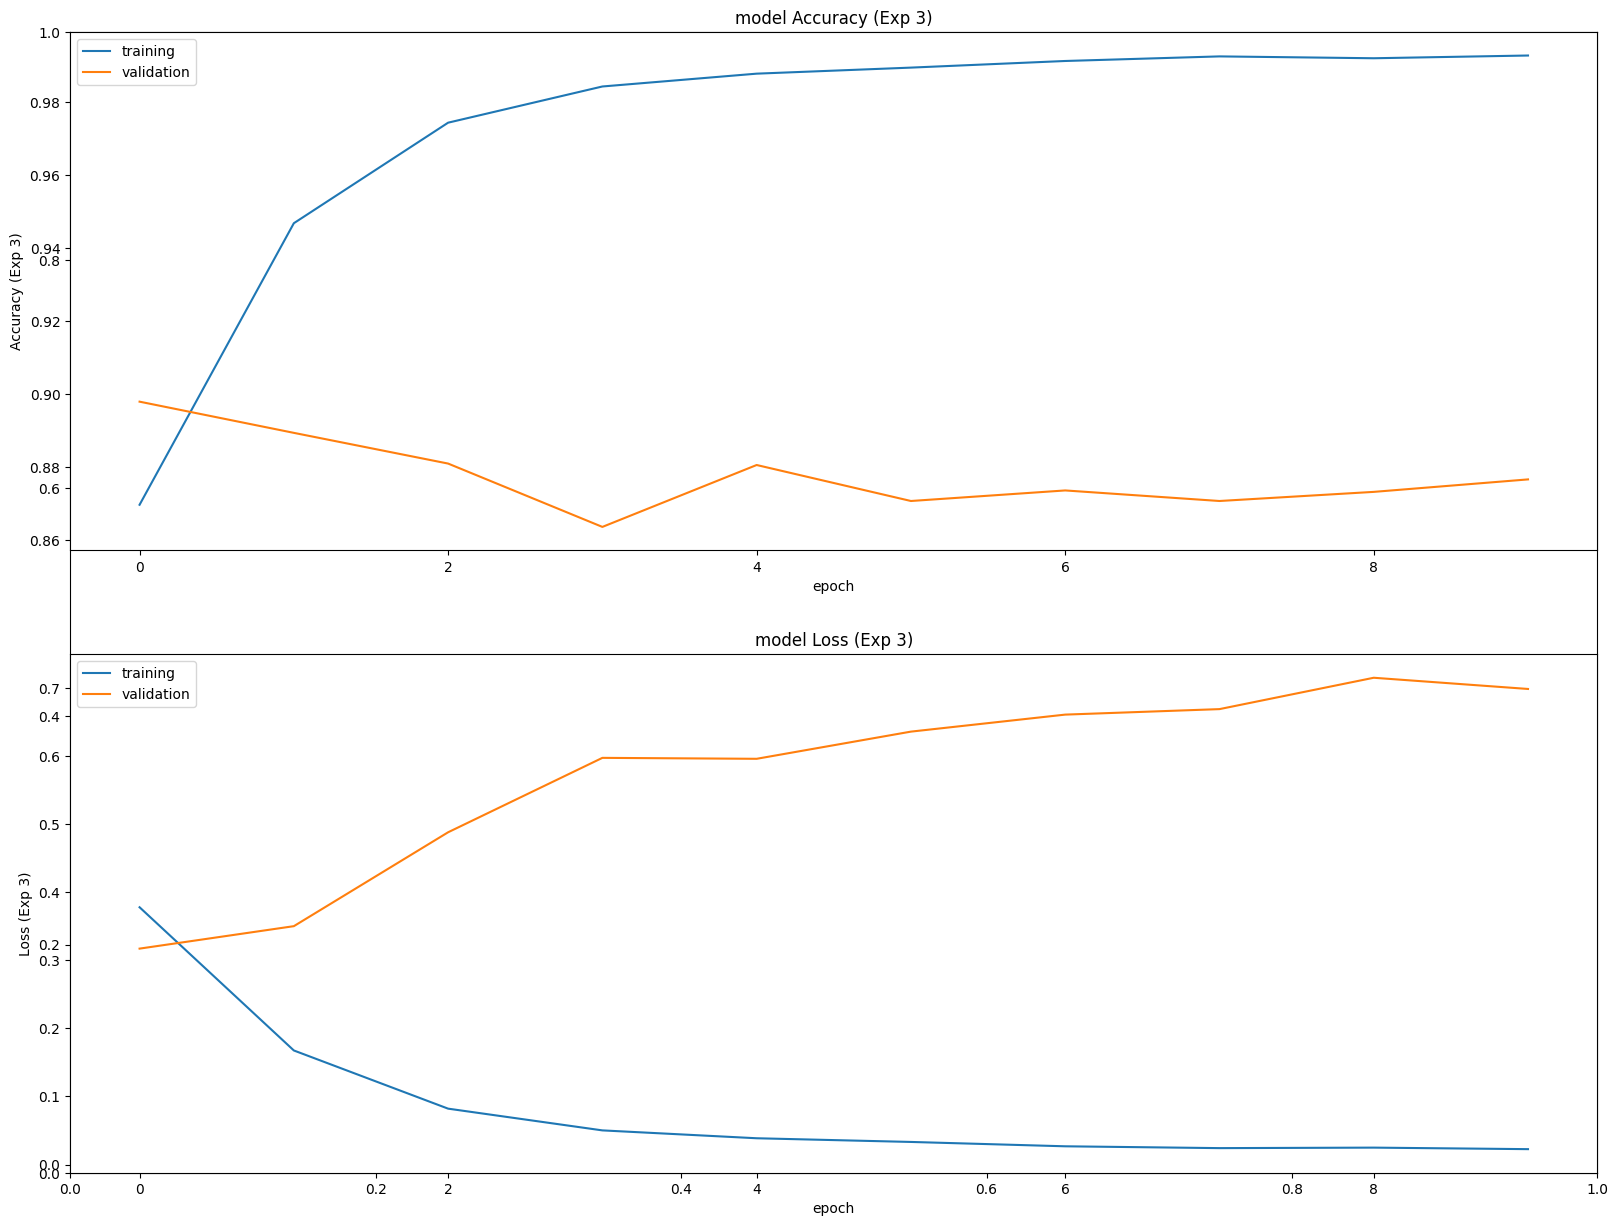

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1900
           1       0.93      0.95      0.94      1900
           2       0.85      0.82      0.83      1900
           3       0.84      0.86      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.876578947368421
Root Mean Square Error: 0.6044788969369446


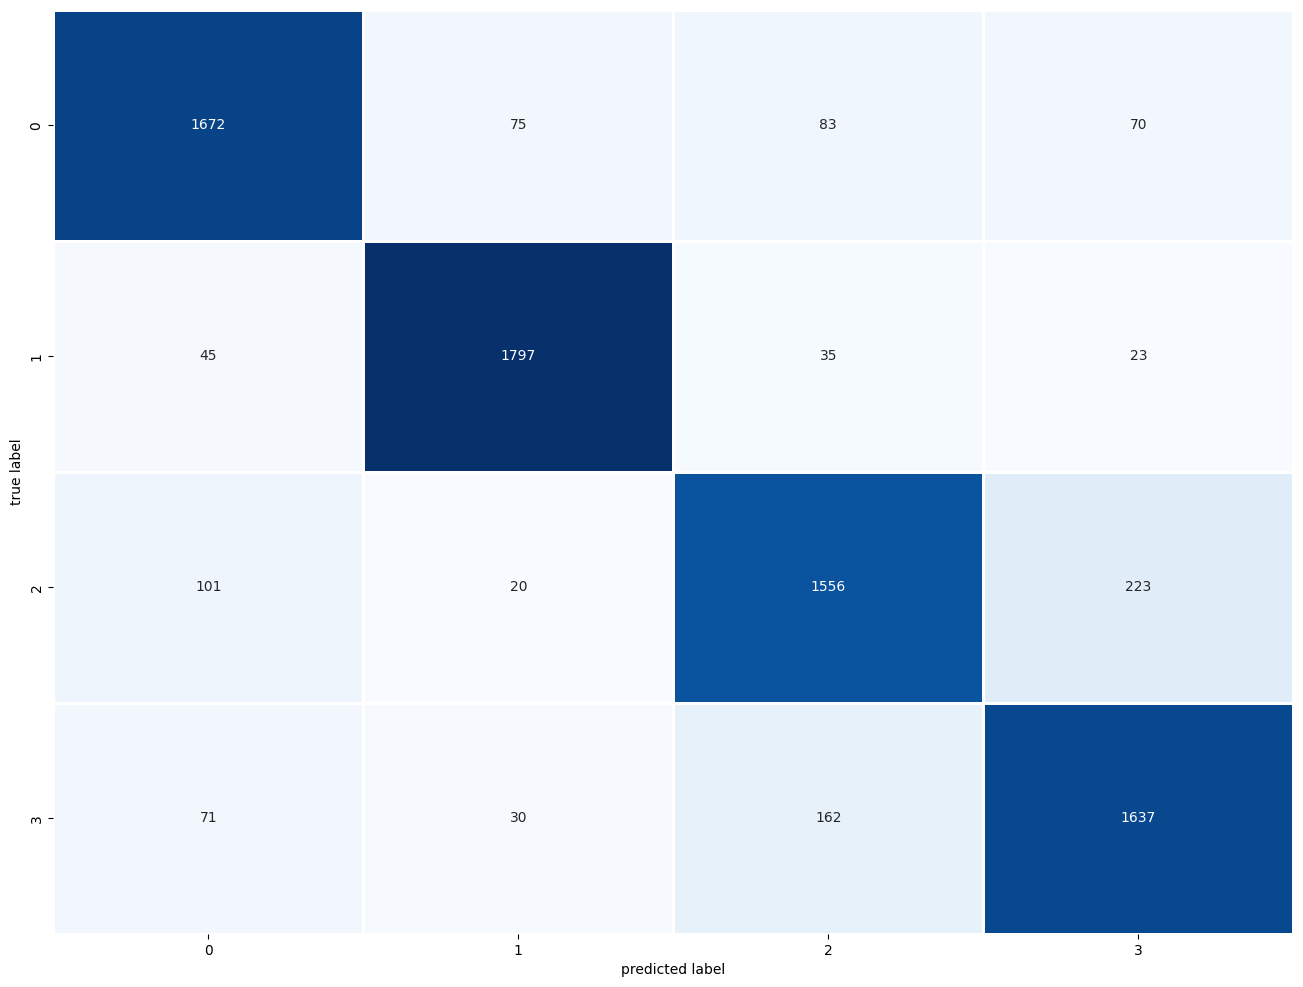

In [11]:
# ======================
# Experiment 3: RNN (128 units)
# ======================
start_time = time.time()

model3 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.SimpleRNN(128),
    layers.Dense(n_classes, activation='softmax')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime3 = end_time - start_time

# Metrics & Visualization
history_df3 = pd.DataFrame(history3.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df3['accuracy'], history_df3['val_accuracy'], 'Accuracy (Exp 3)', 211)
display_training_curves(history_df3['loss'], history_df3['val_loss'], 'Loss (Exp 3)', 212)
plt.show()

y_test3 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes3 = np.argmax(model3.predict(int_test_ds), axis=-1)
print_validation_report(y_test3, pred_classes3)
plot_confusion_matrix(y_test3, pred_classes3)

Experiment 4 stacked RNN layers 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.7980 - loss: 0.5199 - val_accuracy: 0.8958 - val_loss: 0.3149
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9387 - loss: 0.1857 - val_accuracy: 0.8796 - val_loss: 0.3861
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.9713 - loss: 0.0888 - val_accuracy: 0.8803 - val_loss: 0.4768
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9785 - loss: 0.0650 - val_accuracy: 0.8814 - val_loss: 0.5531
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.9847 - loss: 0.0465 - val_accuracy: 0.8730 - val_loss: 0.5965
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.9873 - loss: 0.0402 - val_accuracy: 0.8712 - val_loss: 0.6224
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9881 - loss: 0.0353 - val_accuracy: 0.8624 - val_loss: 0.6997
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9904 -

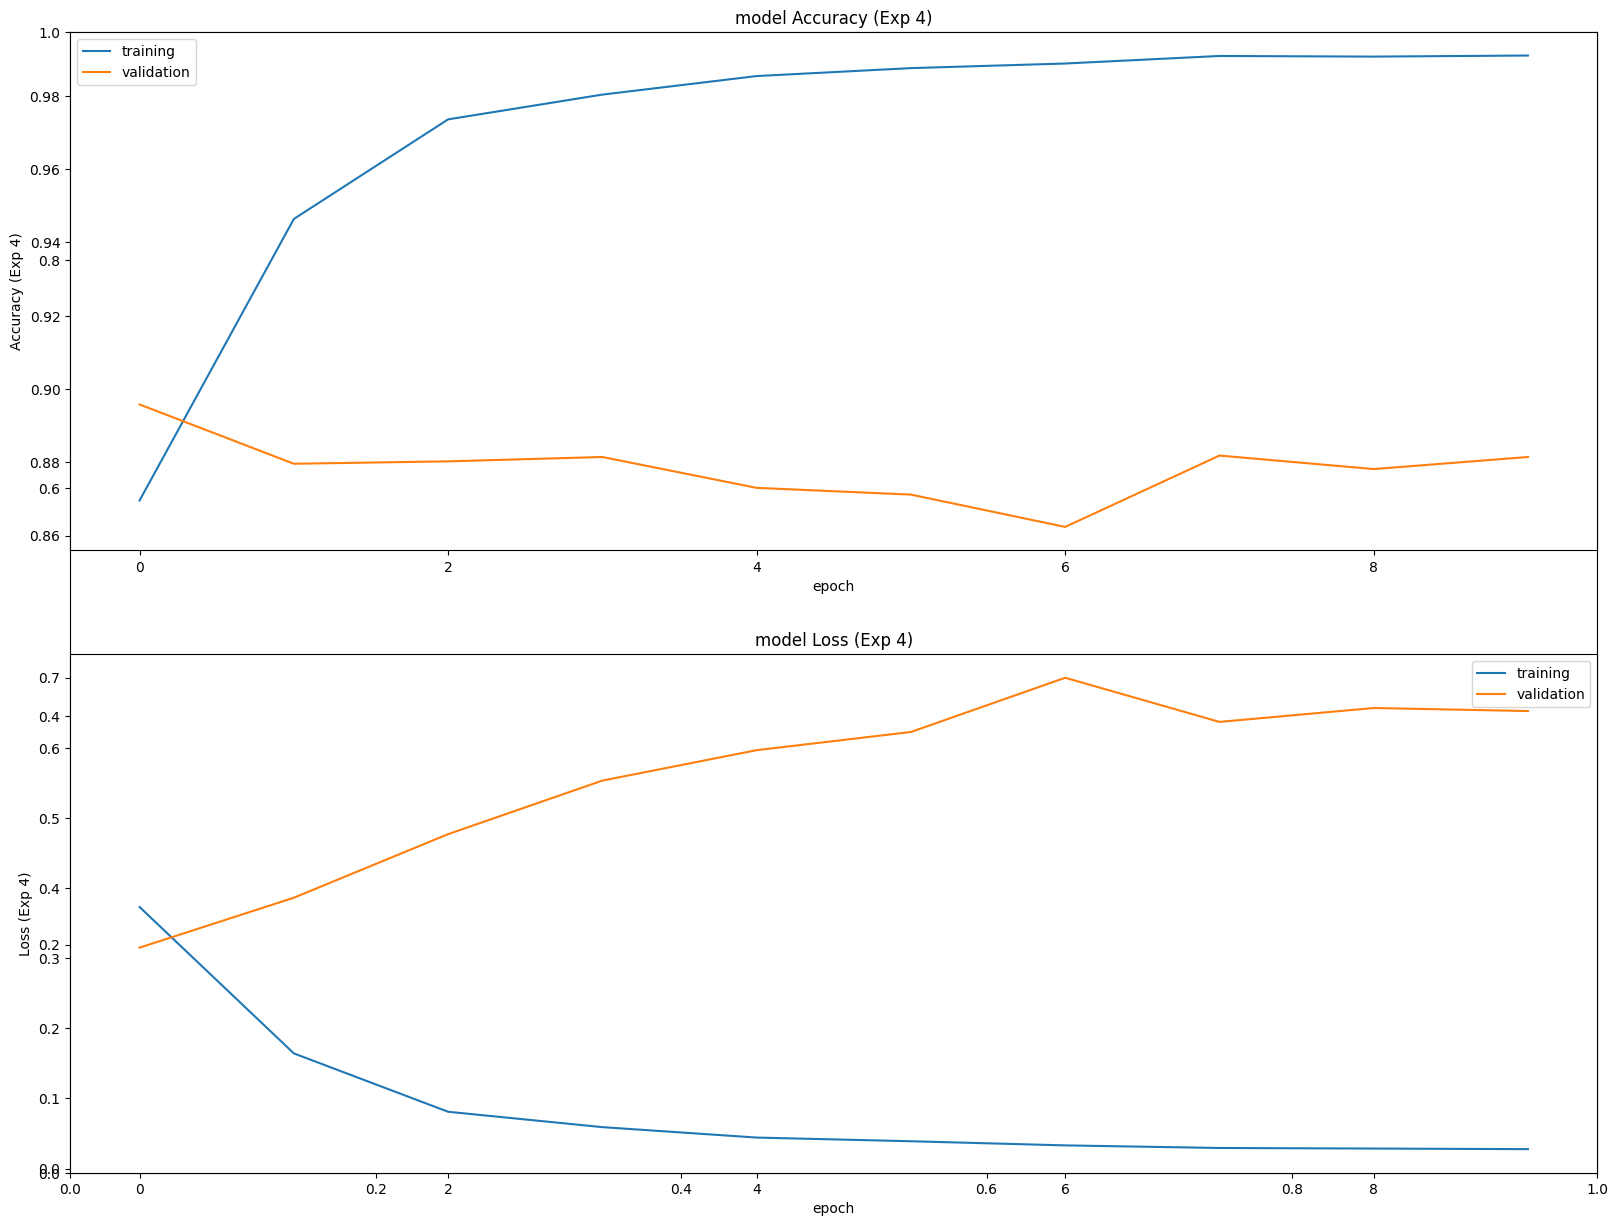

2025-08-01 12:53:40.609678: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1900
           1       0.95      0.95      0.95      1900
           2       0.86      0.81      0.83      1900
           3       0.83      0.89      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8814473684210526
Root Mean Square Error: 0.6029532582041061


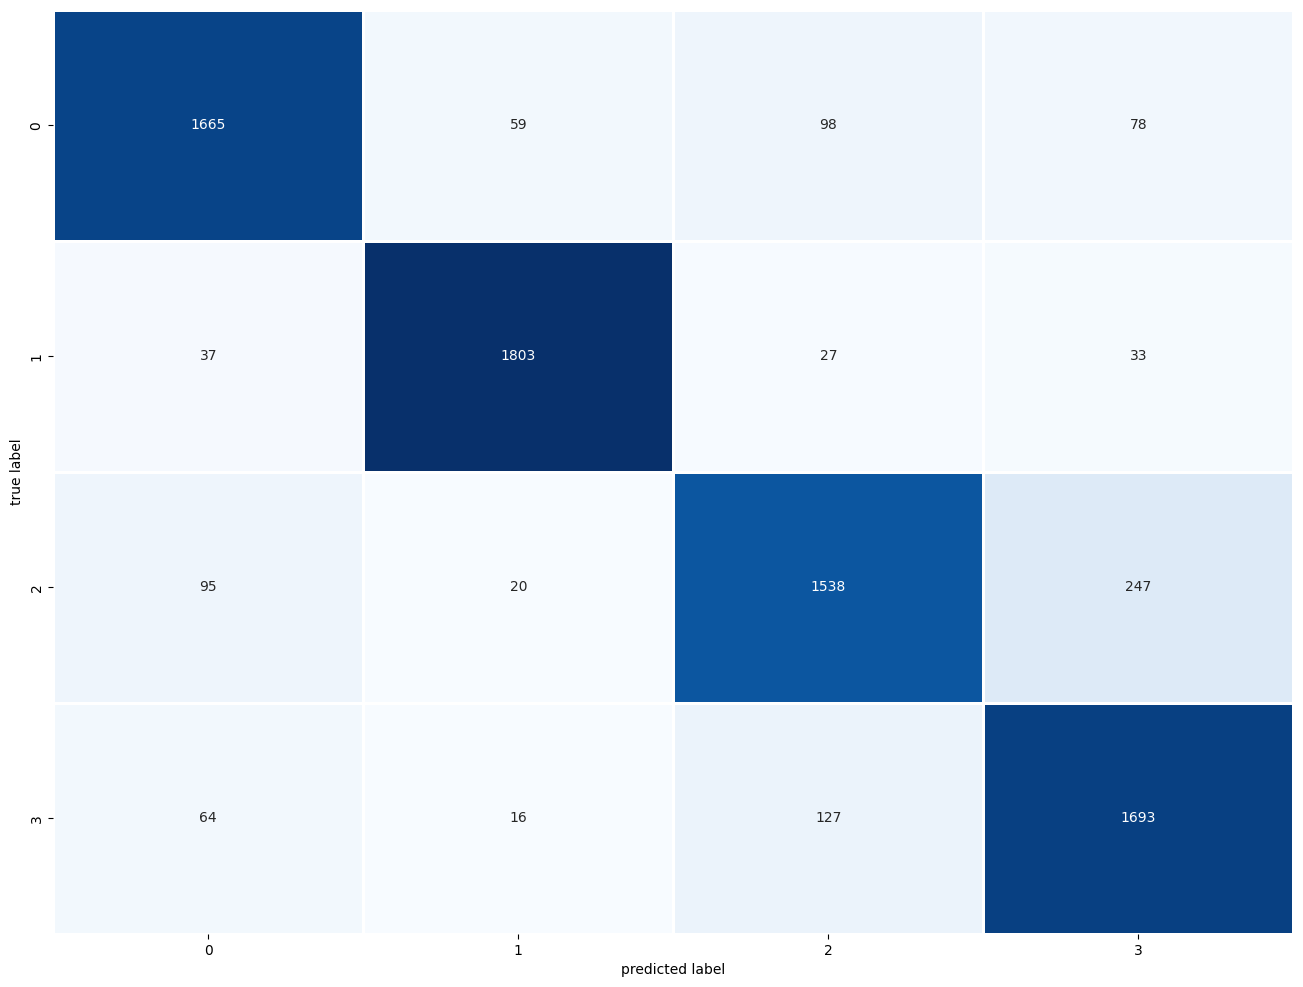

In [12]:
# ======================
# Experiment 4: Stacked RNN (128 → 64 units)
# ======================
start_time = time.time()

model4 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.SimpleRNN(128, return_sequences=True),
    layers.SimpleRNN(64),
    layers.Dense(n_classes, activation='softmax')
])

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime4 = end_time - start_time

# Metrics & Visualization
history_df4 = pd.DataFrame(history4.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df4['accuracy'], history_df4['val_accuracy'], 'Accuracy (Exp 4)', 211)
display_training_curves(history_df4['loss'], history_df4['val_loss'], 'Loss (Exp 4)', 212)
plt.show()

y_test4 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes4 = np.argmax(model4.predict(int_test_ds), axis=-1)
print_validation_report(y_test4, pred_classes4)
plot_confusion_matrix(y_test4, pred_classes4)

Experiment 5 - RNN Bidirectional 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8151 - loss: 0.4849 - val_accuracy: 0.9070 - val_loss: 0.2729
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9506 - loss: 0.1505 - val_accuracy: 0.8946 - val_loss: 0.3491
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9833 - loss: 0.0556 - val_accuracy: 0.8891 - val_loss: 0.4383
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9933 - loss: 0.0245 - val_accuracy: 0.8908 - val_loss: 0.4787
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9951 - loss: 0.0176 - val_accuracy: 0.8750 - val_loss: 0.5653
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9954 - loss: 0.0157 - val_accuracy: 0.8857 - val_loss: 0.5978
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9959 - loss: 0.0140 - val_accuracy: 0.8878 - val_loss: 0.6139
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9963 -

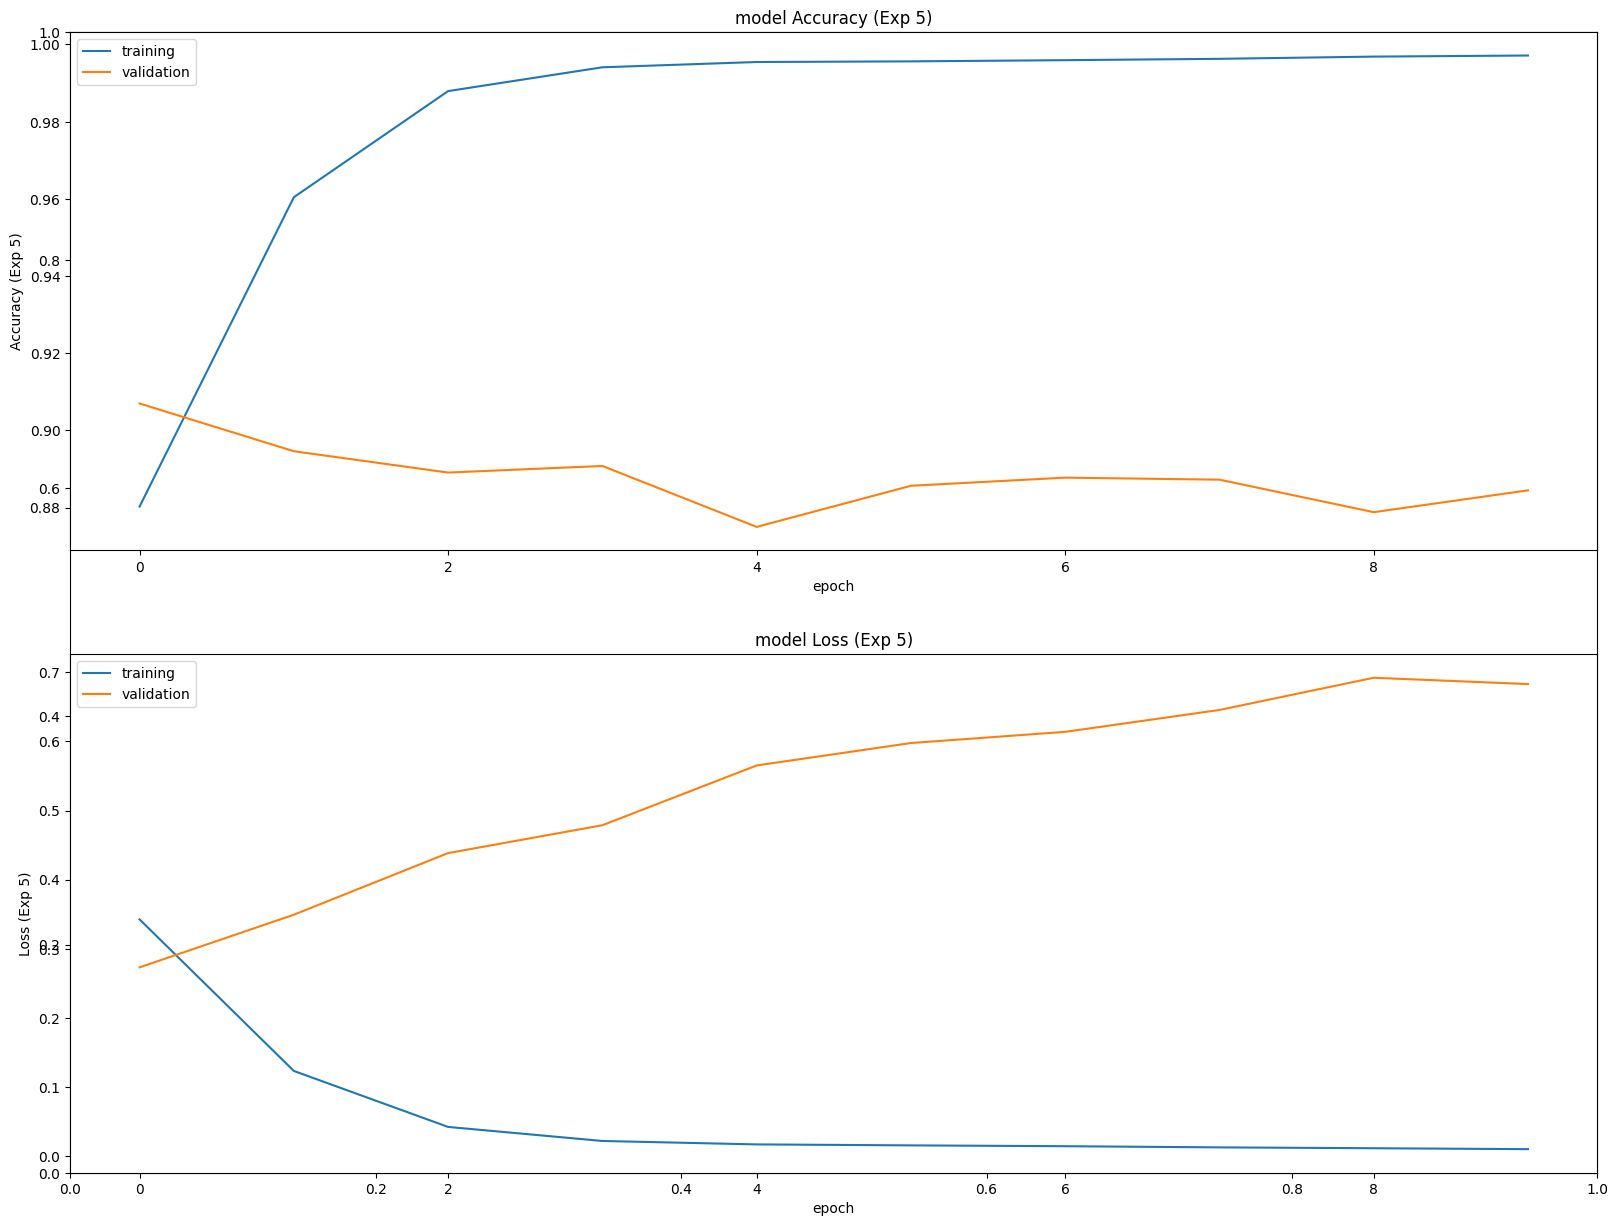

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1900
           1       0.95      0.94      0.95      1900
           2       0.86      0.84      0.85      1900
           3       0.84      0.88      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600

Accuracy Score: 0.8844736842105263
Root Mean Square Error: 0.6012049304696799


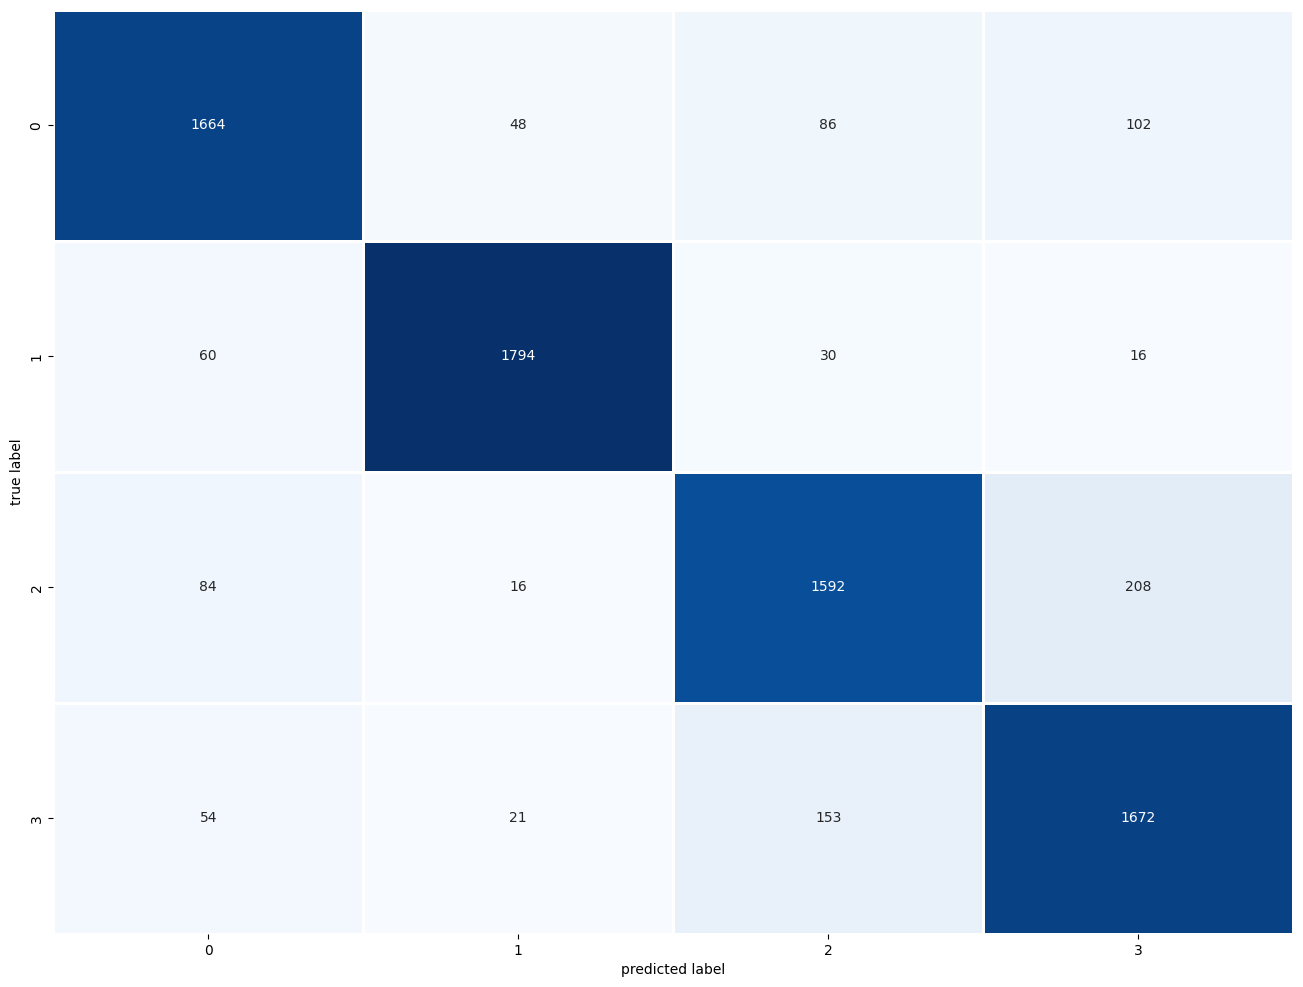

In [13]:
# ======================
# Experiment 5: Bidirectional RNN (64 units)
# ======================
start_time = time.time()

model5 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Dense(n_classes, activation='softmax')
])

model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history5 = model5.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime5 = end_time - start_time

# Metrics & Visualization
history_df5 = pd.DataFrame(history5.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df5['accuracy'], history_df5['val_accuracy'], 'Accuracy (Exp 5)', 211)
display_training_curves(history_df5['loss'], history_df5['val_loss'], 'Loss (Exp 5)', 212)
plt.show()

y_test5 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes5 = np.argmax(model5.predict(int_test_ds), axis=-1)
print_validation_report(y_test5, pred_classes5)
plot_confusion_matrix(y_test5, pred_classes5)

Experiement 6 - LSTM Baseline 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8129 - loss: 0.4915 - val_accuracy: 0.9086 - val_loss: 0.2705
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.9357 - loss: 0.1923 - val_accuracy: 0.9029 - val_loss: 0.2967
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9595 - loss: 0.1218 - val_accuracy: 0.8954 - val_loss: 0.3435
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.9741 - loss: 0.0803 - val_accuracy: 0.8892 - val_loss: 0.4386
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9814 - loss: 0.0548 - val_accuracy: 0.8855 - val_loss: 0.5400
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9861 - loss: 0.0391 - val_accuracy: 0.8897 - val_loss: 0.5667
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9900 - loss: 0.0276 - val_accuracy: 0.8857 - val_loss: 0.5753
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9914 -

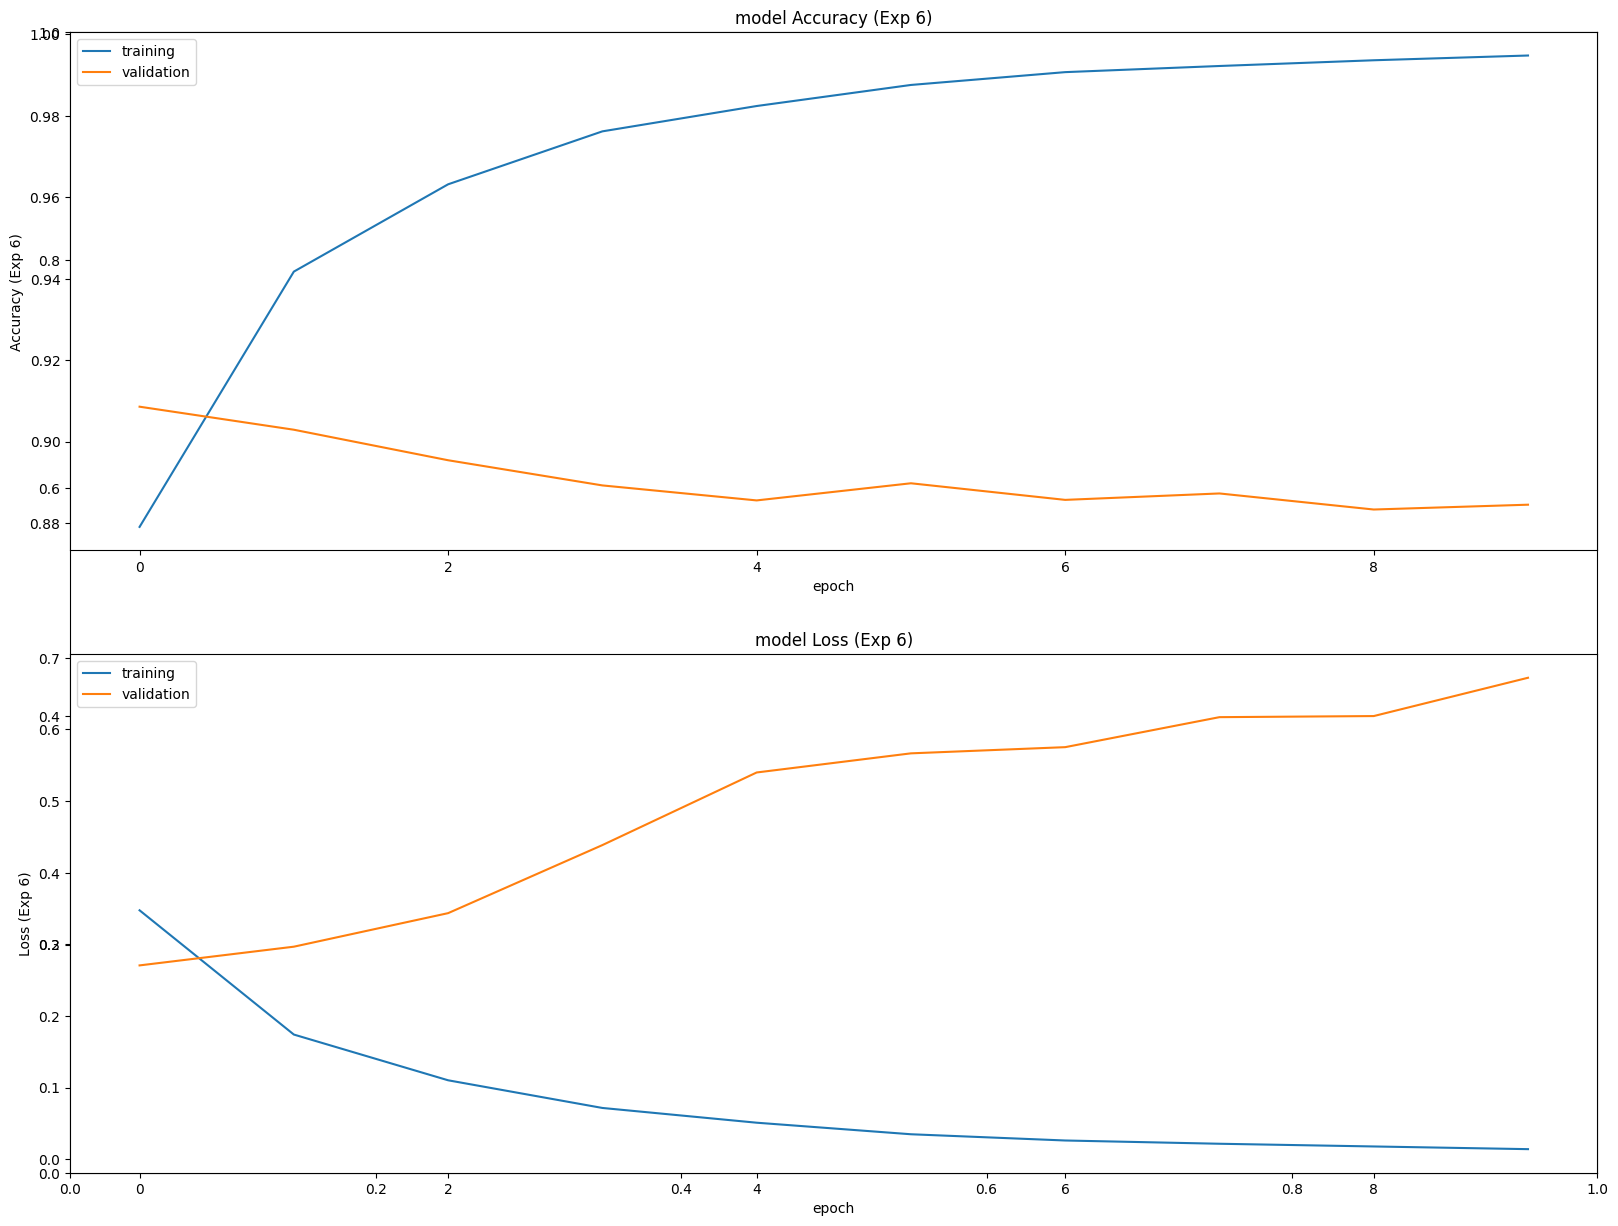

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1900
           1       0.95      0.95      0.95      1900
           2       0.85      0.83      0.84      1900
           3       0.85      0.86      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8844736842105263
Root Mean Square Error: 0.5949347598023271


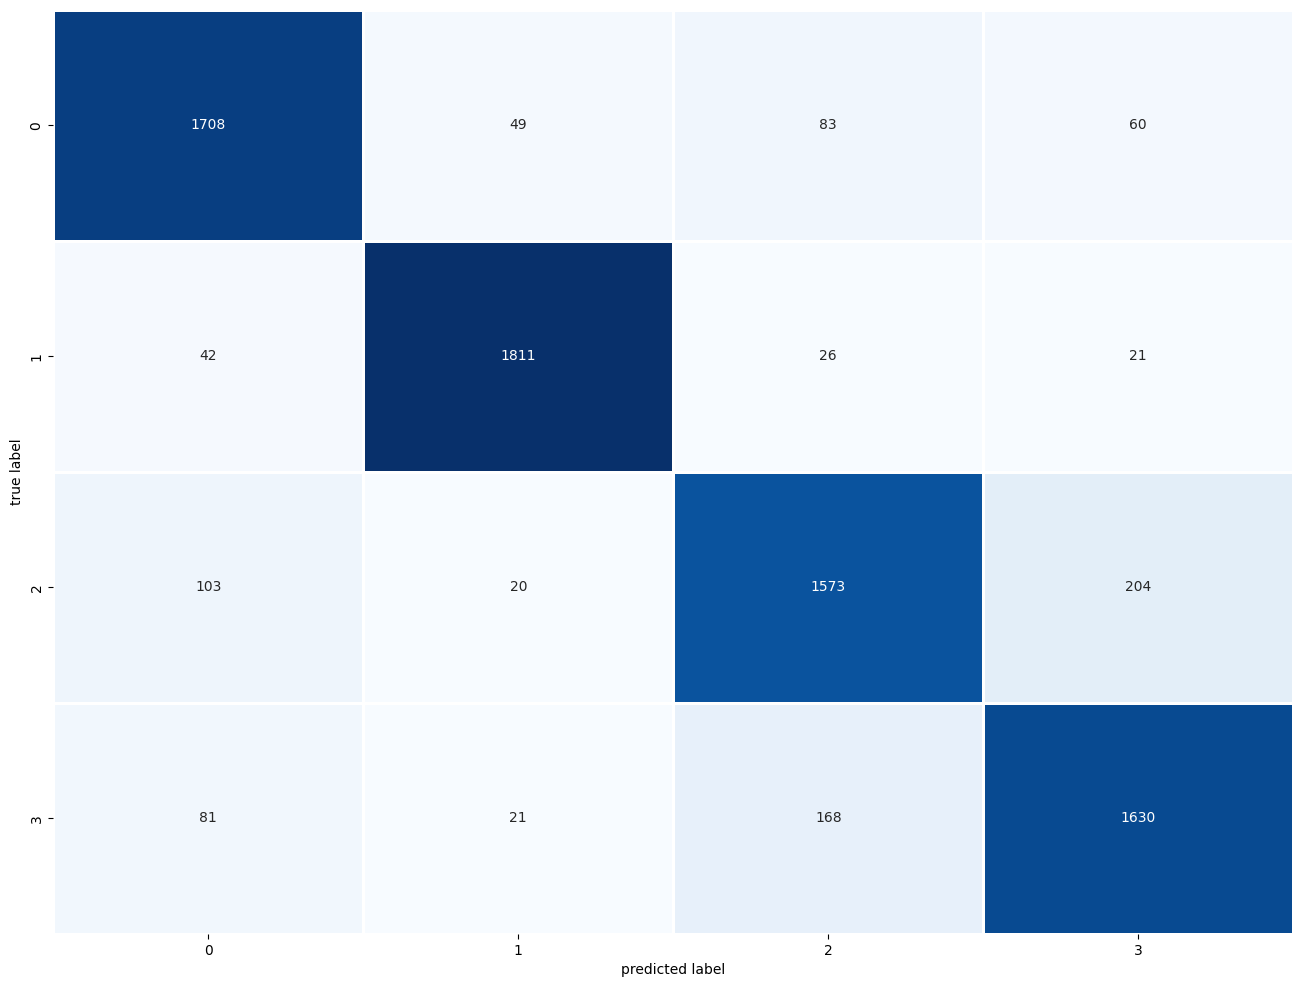

In [14]:
# ======================
# Experiment 6: Baseline LSTM (Single Layer - 128 units)
# ======================
model6 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.LSTM(128),
    layers.Dense(n_classes, activation='softmax')
])

model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history6 = model6.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df6 = pd.DataFrame(history6.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df6['accuracy'], history_df6['val_accuracy'], 'Accuracy (Exp 6)', 211)
display_training_curves(history_df6['loss'], history_df6['val_loss'], 'Loss (Exp 6)', 212)
plt.show()

y_test6 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes6 = np.argmax(model6.predict(int_test_ds), axis=-1)
print_validation_report(y_test6, pred_classes6)
plot_confusion_matrix(y_test6, pred_classes6)

Experiment 7 - Stacked LSTM

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8292 - loss: 0.4585 - val_accuracy: 0.9086 - val_loss: 0.2751
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9386 - loss: 0.1891 - val_accuracy: 0.8997 - val_loss: 0.3077
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9628 - loss: 0.1188 - val_accuracy: 0.8912 - val_loss: 0.3814
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9771 - loss: 0.0725 - val_accuracy: 0.8857 - val_loss: 0.4498
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9839 - loss: 0.0508 - val_accuracy: 0.8804 - val_loss: 0.5156
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9886 - loss: 0.0353 - val_accuracy: 0.8788 - val_loss: 0.6055
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9910 - loss: 0.0277 - val_accuracy: 0.8813 - val_loss: 0.6044
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9933 -

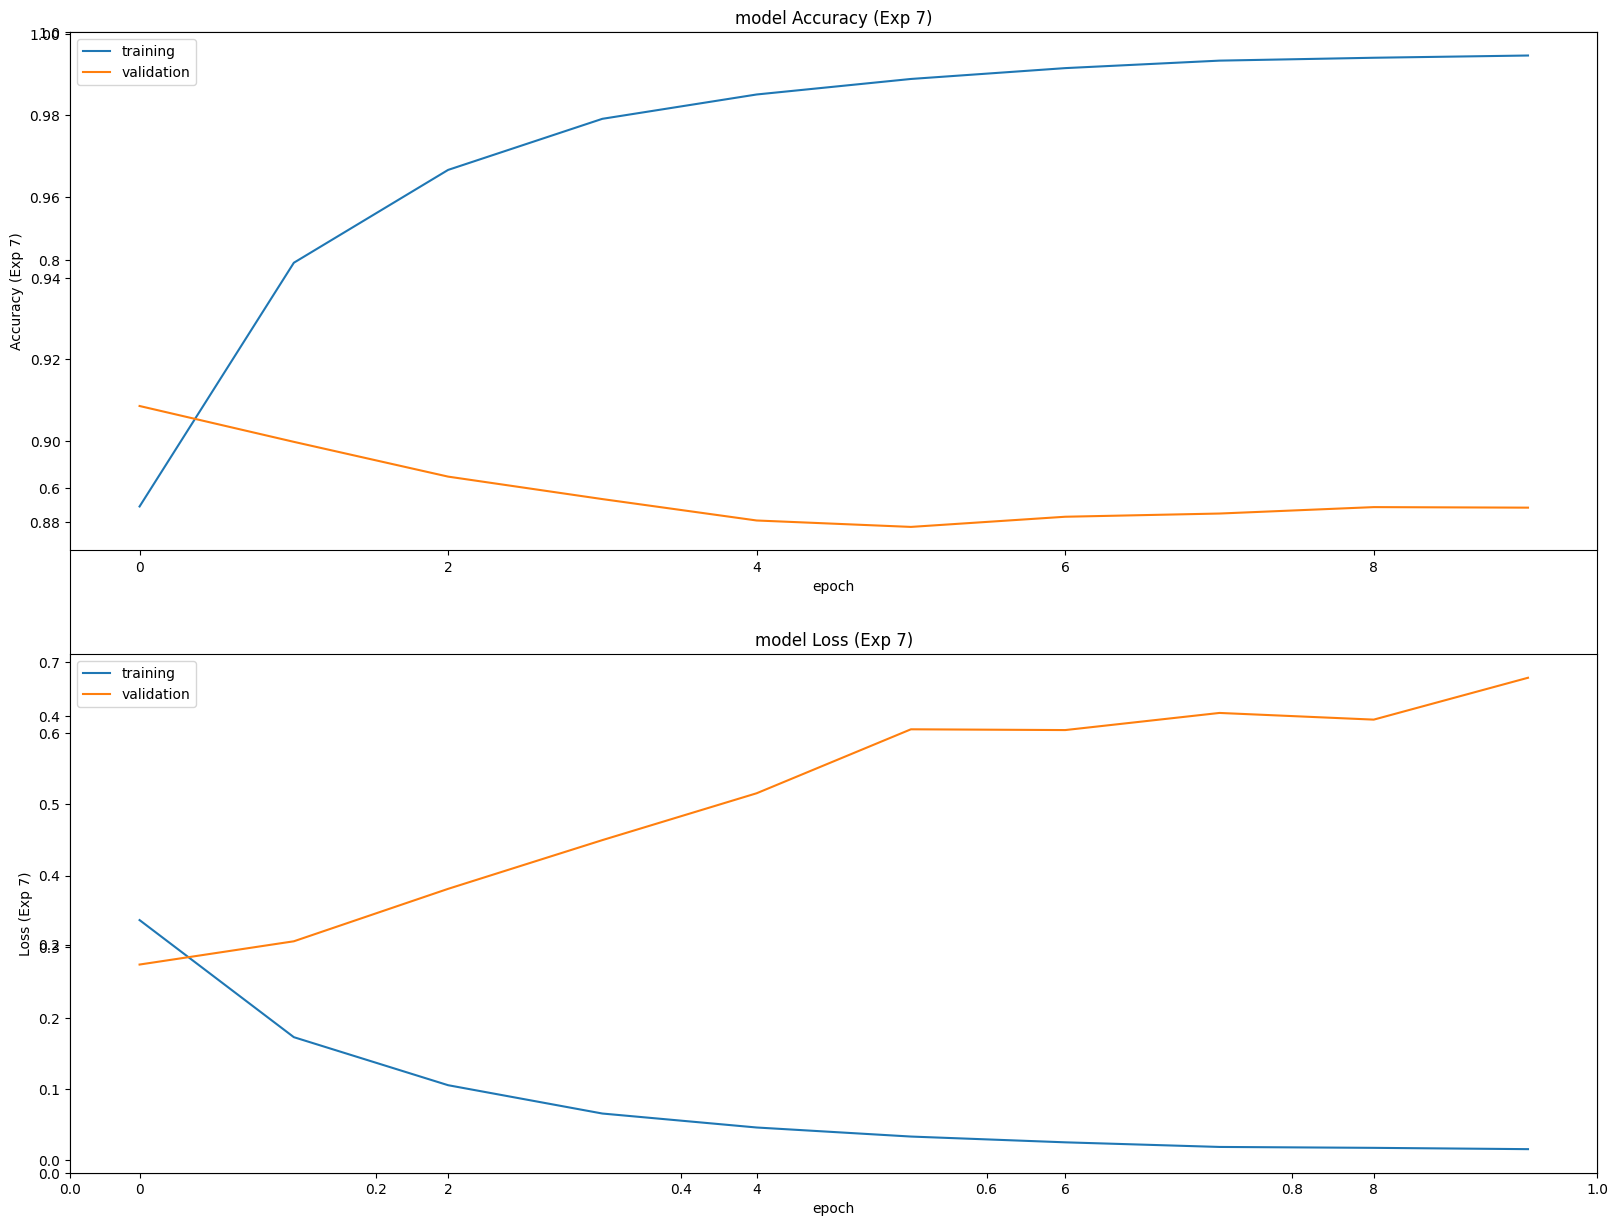

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1900
           1       0.96      0.94      0.95      1900
           2       0.84      0.85      0.85      1900
           3       0.84      0.86      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8835526315789474
Root Mean Square Error: 0.5916079783099616


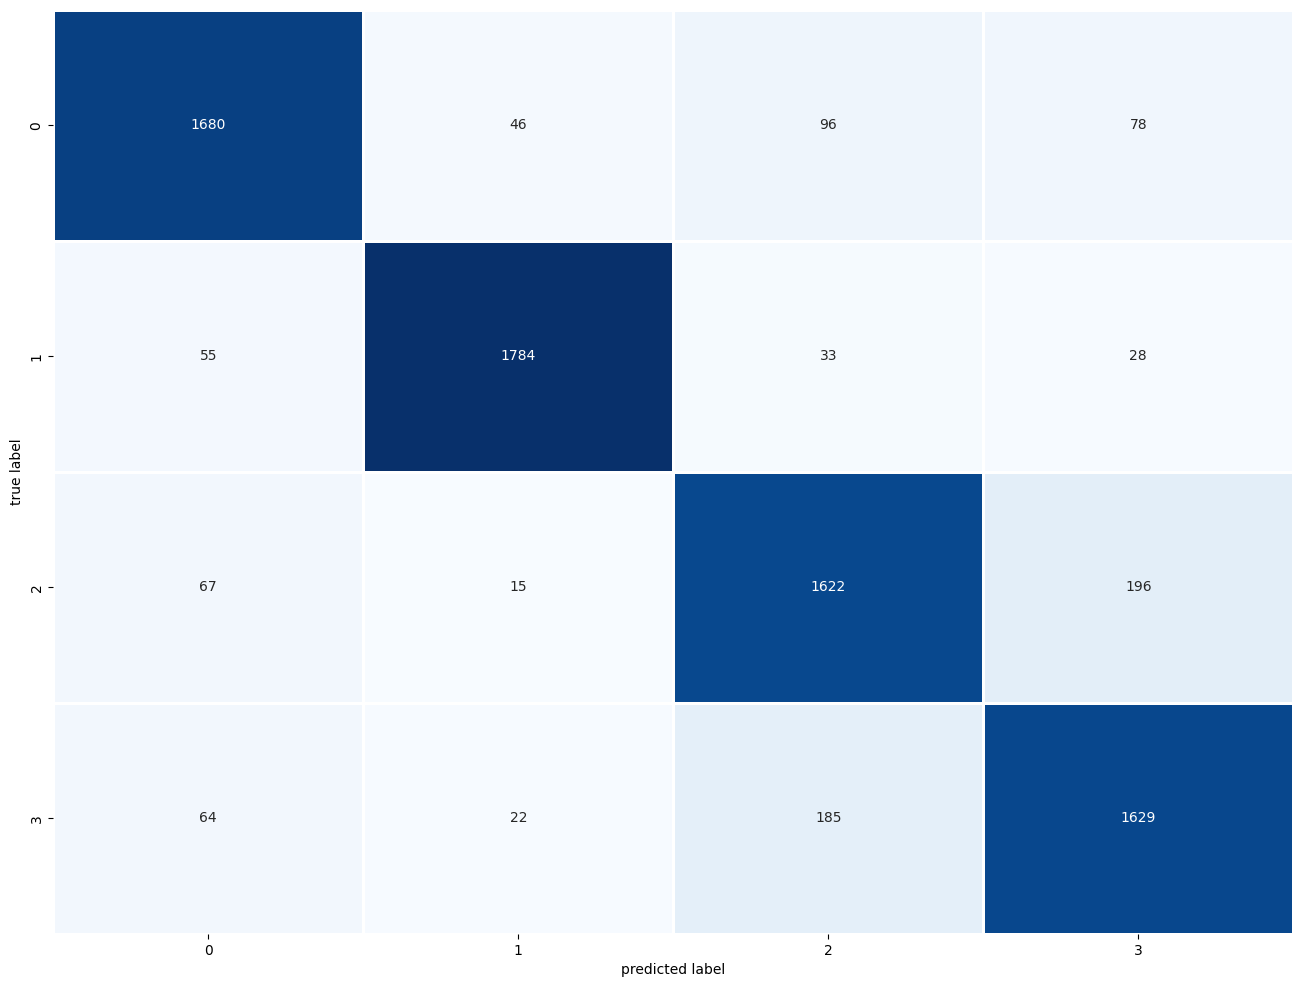

In [15]:
# ======================
# Experiment 7: Stacked LSTM (128 → 64)
# ======================
model7 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(n_classes, activation='softmax')
])

model7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history7 = model7.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df7 = pd.DataFrame(history7.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df7['accuracy'], history_df7['val_accuracy'], 'Accuracy (Exp 7)', 211)
display_training_curves(history_df7['loss'], history_df7['val_loss'], 'Loss (Exp 7)', 212)
plt.show()

y_test7 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes7 = np.argmax(model7.predict(int_test_ds), axis=-1)
print_validation_report(y_test7, pred_classes7)
plot_confusion_matrix(y_test7, pred_classes7)

Experiment 8 LSTM - bidirectional 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8289 - loss: 0.4595 - val_accuracy: 0.9118 - val_loss: 0.2599
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9390 - loss: 0.1810 - val_accuracy: 0.9057 - val_loss: 0.2876
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9621 - loss: 0.1152 - val_accuracy: 0.8968 - val_loss: 0.3461
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9763 - loss: 0.0723 - val_accuracy: 0.8899 - val_loss: 0.4351
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9853 - loss: 0.0450 - val_accuracy: 0.8892 - val_loss: 0.4989
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9893 - loss: 0.0308 - val_accuracy: 0.8880 - val_loss: 0.5611
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9921 - loss: 0.0220 - val_accuracy: 0.8853 - val_loss: 0.5706
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9945 -

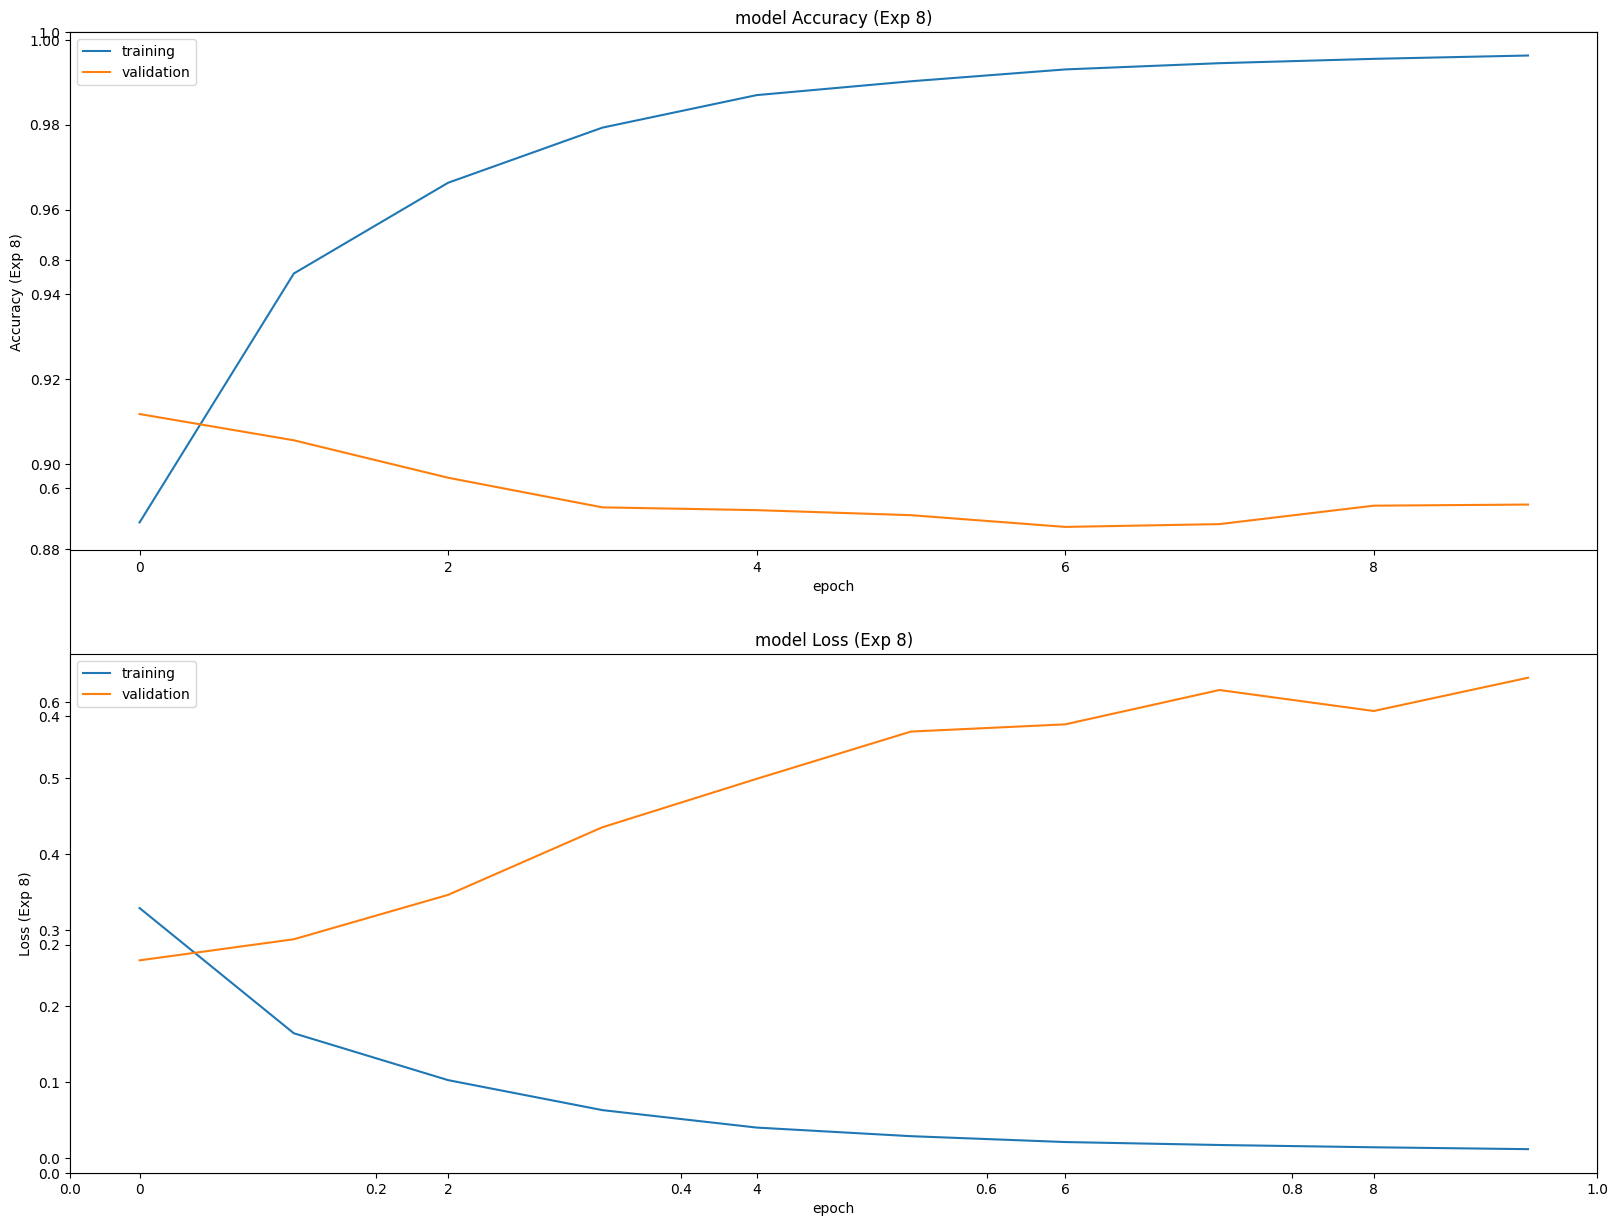

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1900
           1       0.94      0.97      0.96      1900
           2       0.86      0.83      0.85      1900
           3       0.86      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8905263157894737
Root Mean Square Error: 0.5804943446843616


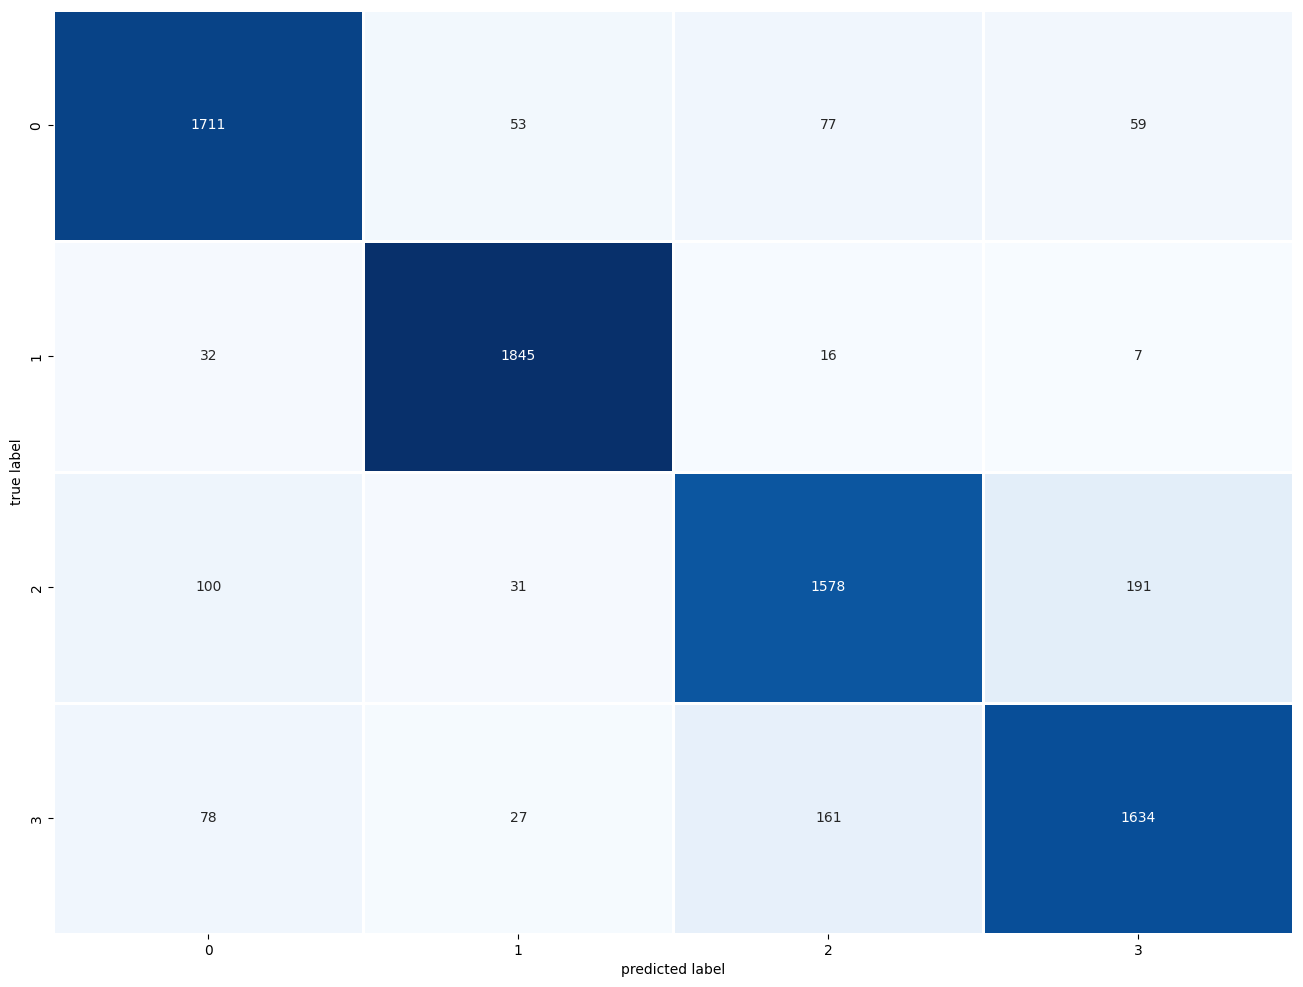

In [16]:
# ======================
# Experiment 8: Bidirectional LSTM (128 units)
# ======================
model8 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(n_classes, activation='softmax')
])

model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history8 = model8.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df8 = pd.DataFrame(history8.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df8['accuracy'], history_df8['val_accuracy'], 'Accuracy (Exp 8)', 211)
display_training_curves(history_df8['loss'], history_df8['val_loss'], 'Loss (Exp 8)', 212)
plt.show()

y_test8 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes8 = np.argmax(model8.predict(int_test_ds), axis=-1)
print_validation_report(y_test8, pred_classes8)
plot_confusion_matrix(y_test8, pred_classes8)

Experiment 9 - LSTM -Dropout Regularizatio

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8132 - loss: 0.4867 - val_accuracy: 0.9067 - val_loss: 0.2773
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9353 - loss: 0.2011 - val_accuracy: 0.9053 - val_loss: 0.3023
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9598 - loss: 0.1294 - val_accuracy: 0.8875 - val_loss: 0.3705
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9746 - loss: 0.0829 - val_accuracy: 0.8812 - val_loss: 0.4820
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9828 - loss: 0.0554 - val_accuracy: 0.8811 - val_loss: 0.5108
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9867 - loss: 0.0409 - val_accuracy: 0.8774 - val_loss: 0.5208
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9890 - loss: 0.0336 - val_accuracy: 0.8829 - val_loss: 0.5485
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9917 -

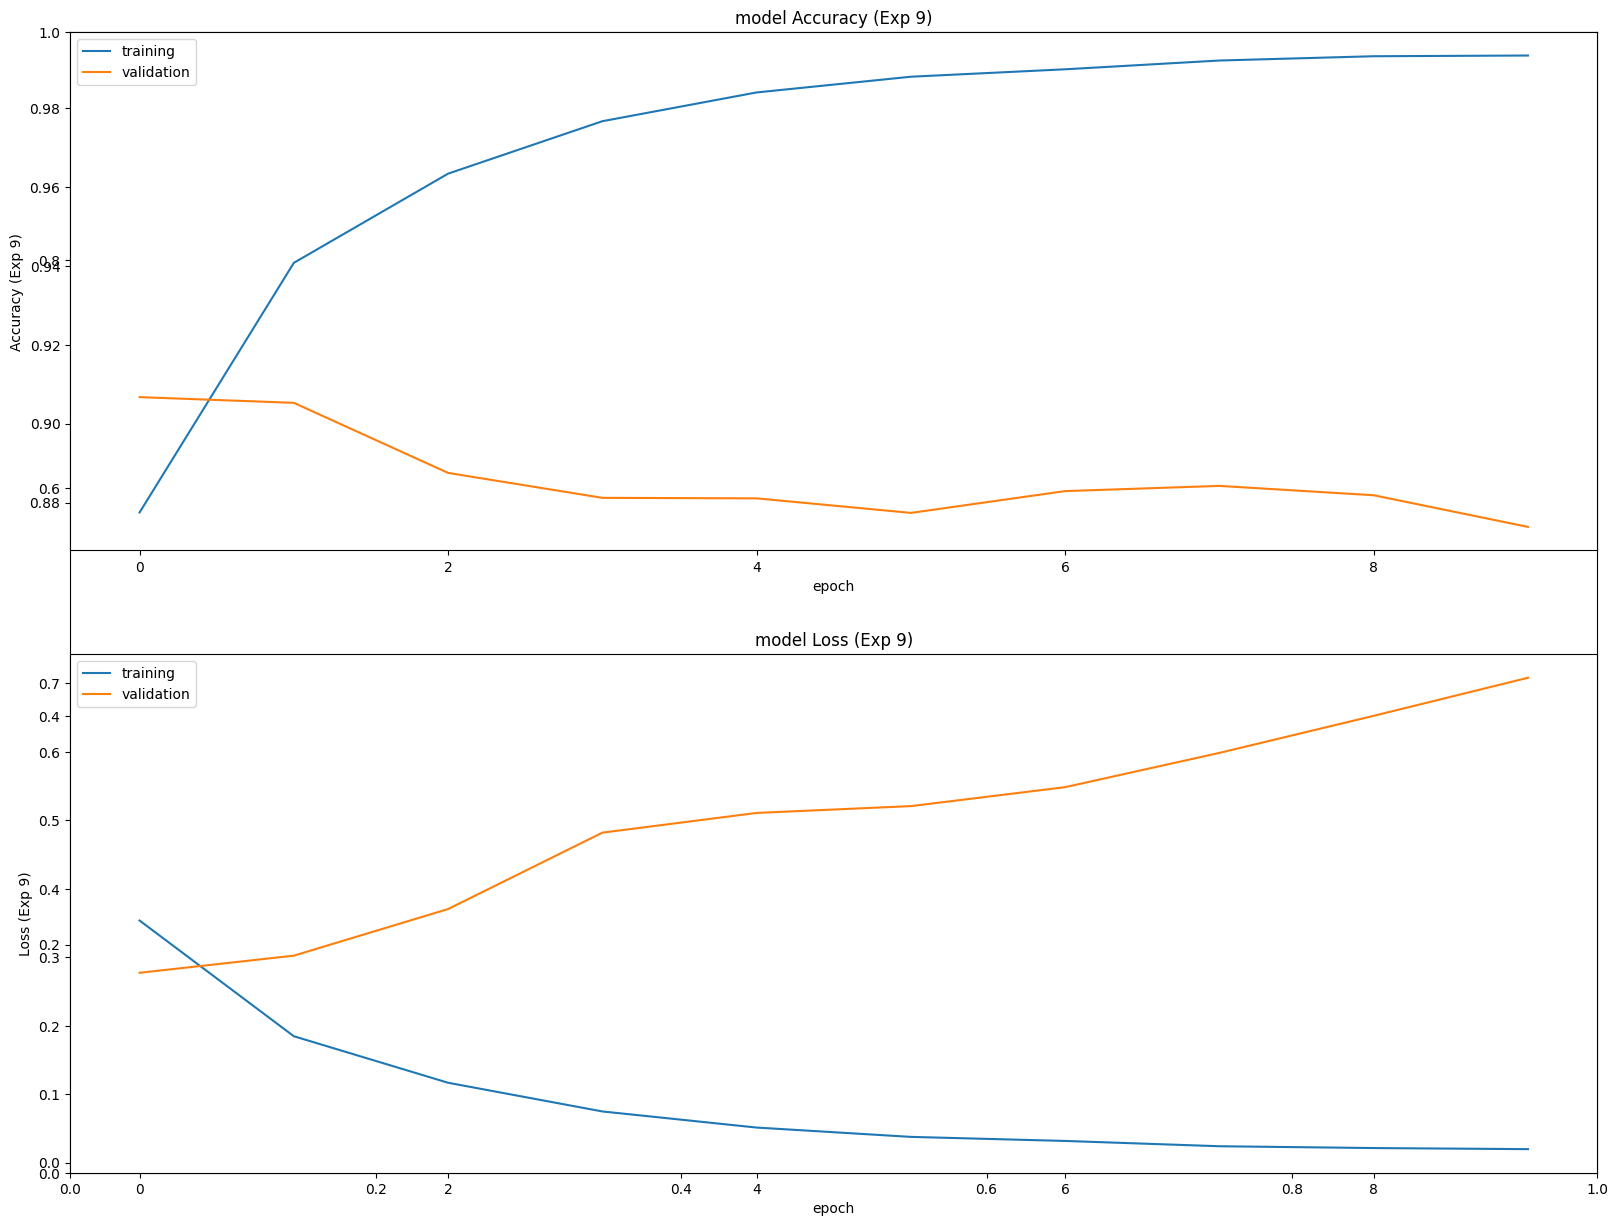

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1900
           1       0.96      0.94      0.95      1900
           2       0.84      0.82      0.83      1900
           3       0.86      0.82      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8738157894736842
Root Mean Square Error: 0.6202715873754522


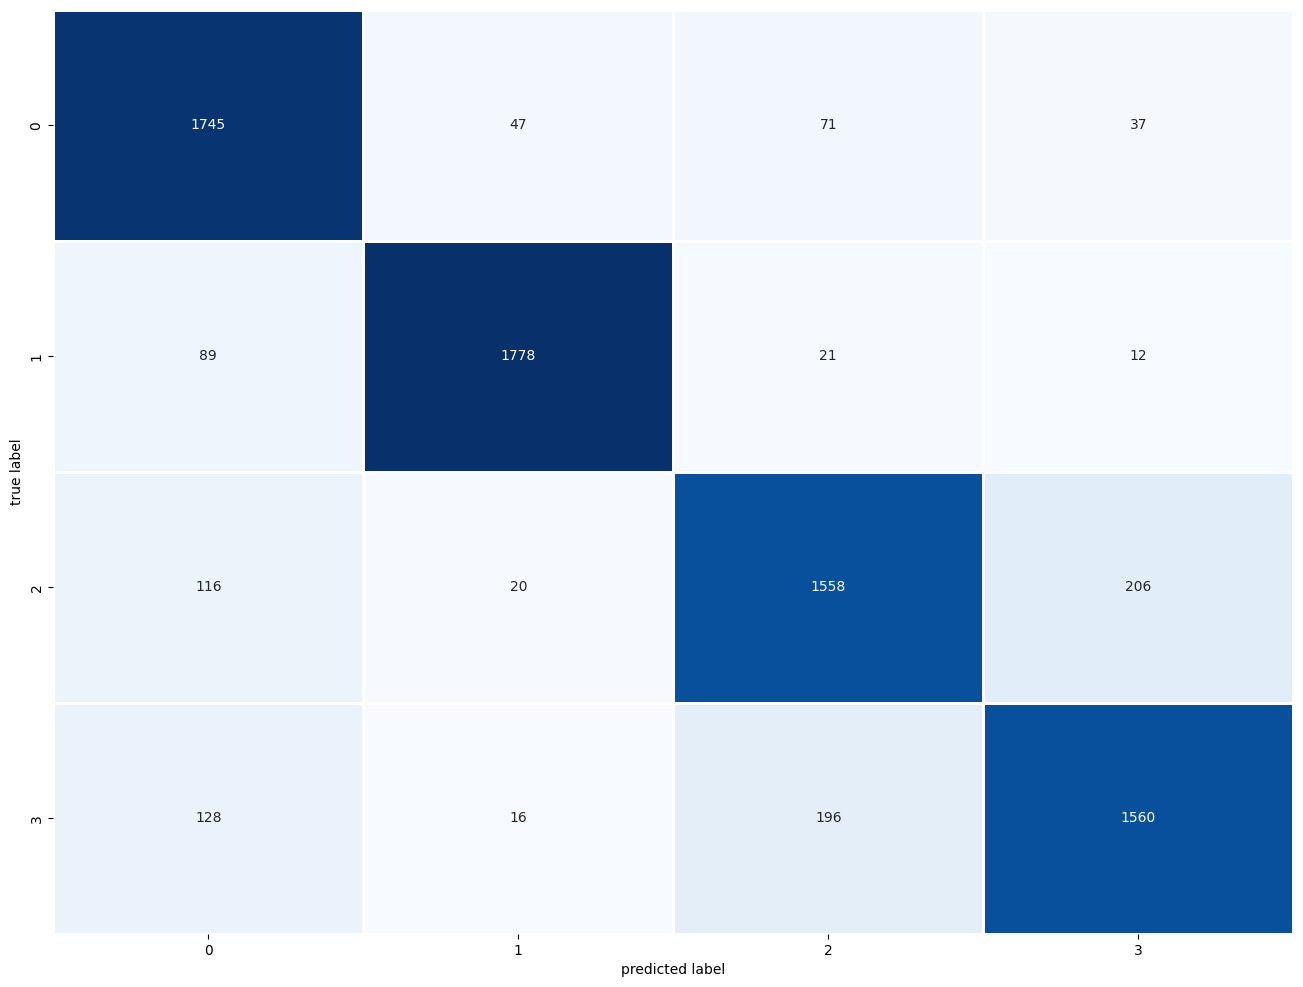

In [17]:
# ======================
# Experiment 9: Stacked LSTM with Dropout Regularization (Sparse Categorical)
# ======================

import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumptions:
# 1. text_vectorization is already adapted to your training text
# 2. int_train_ds and int_test_ds are preprocessed datasets yielding (features, integer labels)
# 3. n_classes is defined as the number of unique labels

embedding_dim = 128  # Embedding dimension (can be tuned)

# ======================
# 1. Build Model
# ======================
model9 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=embedding_dim,
                     mask_zero=True),   # Trainable embeddings
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

# ======================
# 2. Compile Model (Using SparseCategoricalCrossentropy for integer labels)
# ======================
model9.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model9.summary()

# ======================
# 3. Train Model
# ======================
history9 = model9.fit(
    int_train_ds,
    validation_data=int_test_ds,
    epochs=10
)

# ======================
# 4. Convert Training History to DataFrame
# ======================
history_df9 = pd.DataFrame(history9.history)

# ======================
# 5. Visualization
# ======================
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df9['accuracy'], history_df9['val_accuracy'], 'Accuracy (Exp 9)', 211)
display_training_curves(history_df9['loss'], history_df9['val_loss'], 'Loss (Exp 9)', 212)
plt.show()

# ======================
# 6. Evaluation: Predictions & Metrics
# ======================
y_test9 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes9 = np.argmax(model9.predict(int_test_ds), axis=-1)

print_validation_report(y_test9, pred_classes9)
plot_confusion_matrix(y_test9, pred_classes9)

Experiment 10 - 1D CNN

Epoch 1/10


/home/jameslinux/anaconda3/envs/tf_3.10/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.8073 - loss: 0.5291 - val_accuracy: 0.9103 - val_loss: 0.2657
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.9443 - loss: 0.1666 - val_accuracy: 0.9074 - val_loss: 0.3011
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9772 - loss: 0.0720 - val_accuracy: 0.8986 - val_loss: 0.3794
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9903 - loss: 0.0341 - val_accuracy: 0.8997 - val_loss: 0.4433
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9942 - loss: 0.0211 - val_accuracy: 0.8967 - val_loss: 0.5505
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9949 - loss: 0.0153 - val_accuracy: 0.8907 - val_loss: 0.6286
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9950 - loss: 0.0139 - val_accuracy: 0.8889 - val_loss: 0.6876
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9956 - loss: 0.01

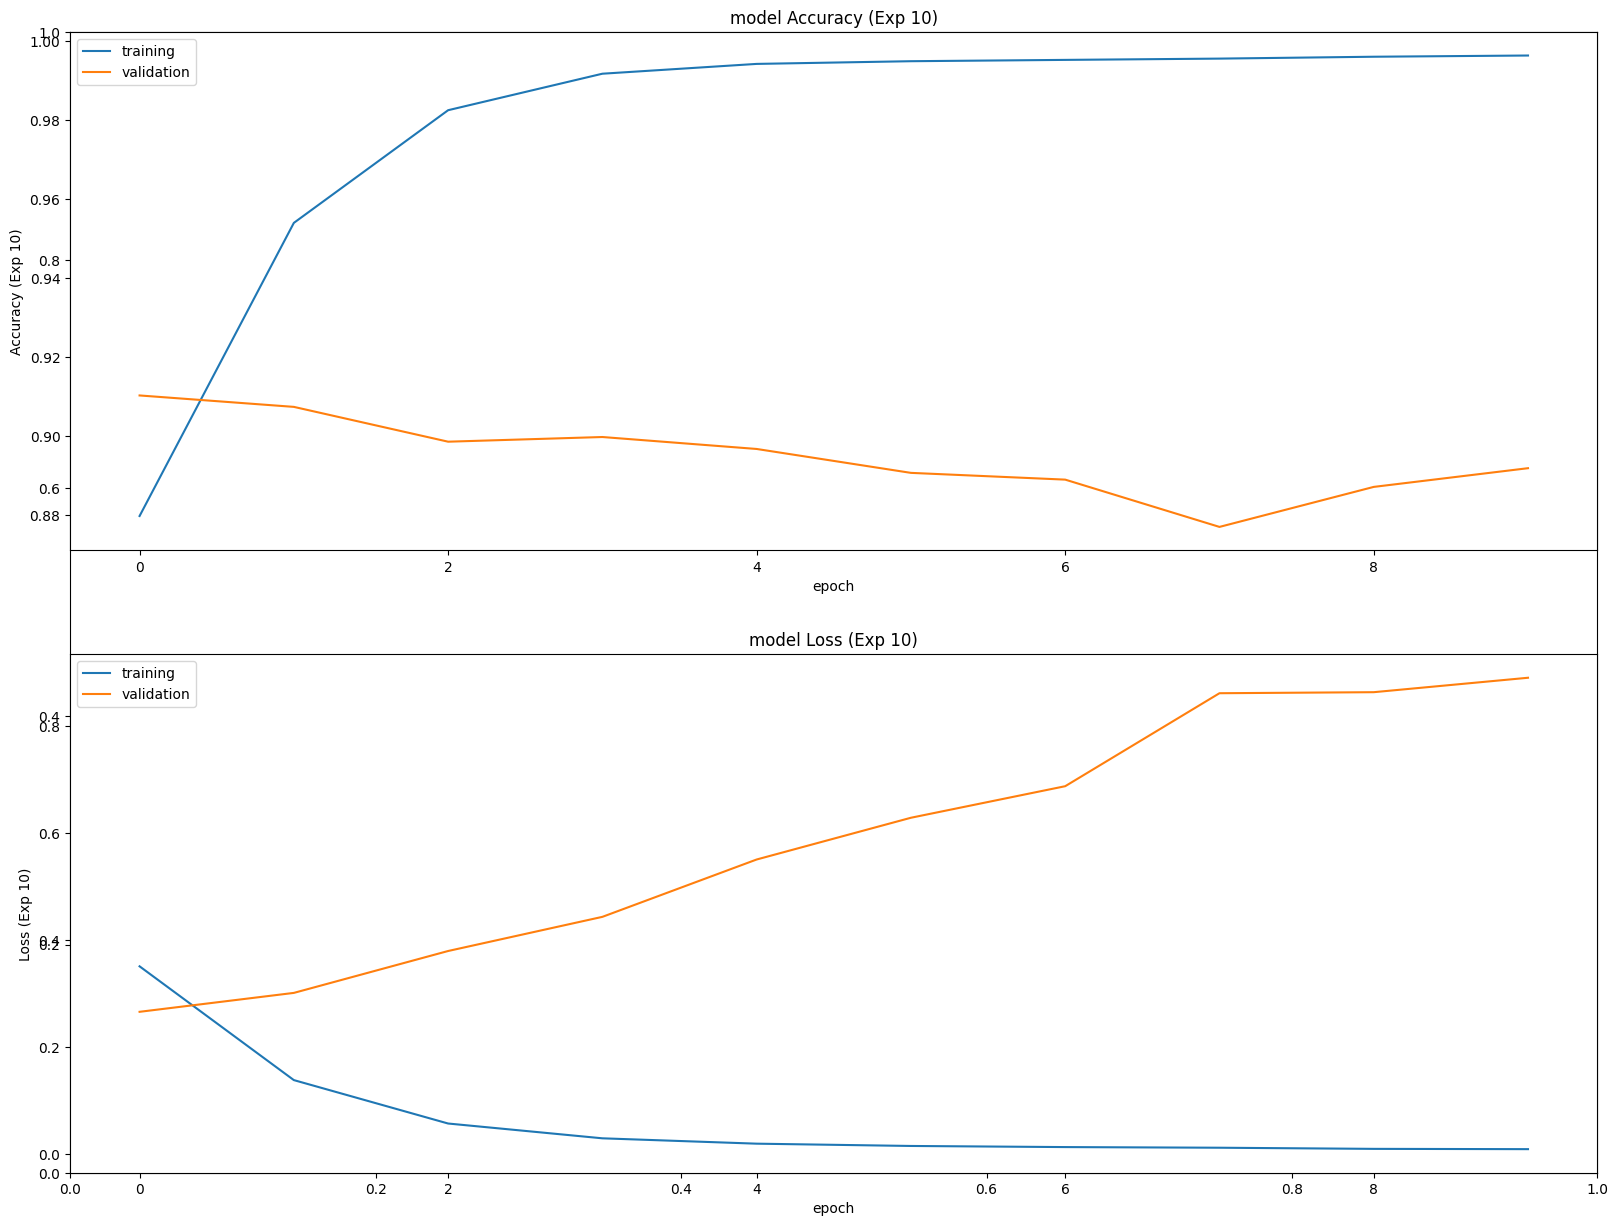

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1900
           1       0.93      0.97      0.95      1900
           2       0.89      0.82      0.85      1900
           3       0.85      0.88      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8918421052631579
Root Mean Square Error: 0.5603100645366391


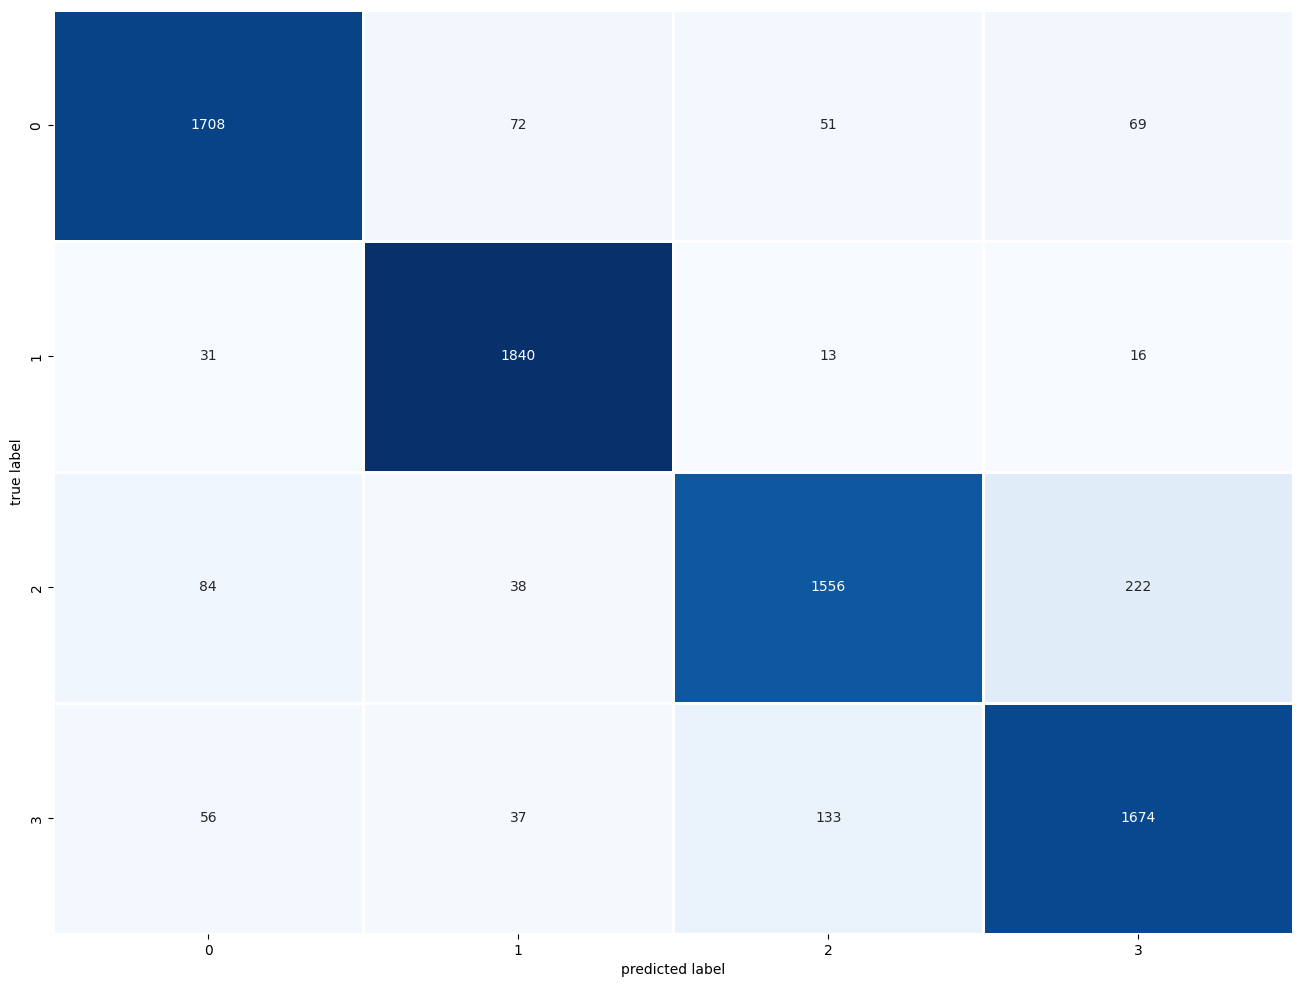

In [18]:
# ======================
# Experiment 10: 1D CNN
# ======================
model10 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history10 = model10.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df10 = pd.DataFrame(history10.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df10['accuracy'], history_df10['val_accuracy'], 'Accuracy (Exp 10)', 211)
display_training_curves(history_df10['loss'], history_df10['val_loss'], 'Loss (Exp 10)', 212)
plt.show()

y_test10 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes10 = np.argmax(model10.predict(int_test_ds), axis=-1)
print_validation_report(y_test10, pred_classes10)
plot_confusion_matrix(y_test10, pred_classes10)

Experiment 11 -GRU Baseline

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.8087 - loss: 0.5094 - val_accuracy: 0.9076 - val_loss: 0.2719
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9353 - loss: 0.1906 - val_accuracy: 0.9012 - val_loss: 0.2967
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9594 - loss: 0.1217 - val_accuracy: 0.8939 - val_loss: 0.3613
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9747 - loss: 0.0775 - val_accuracy: 0.8822 - val_loss: 0.4765
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9831 - loss: 0.0528 - val_accuracy: 0.8672 - val_loss: 0.5767
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9874 - loss: 0.0379 - val_accuracy: 0.8800 - val_loss: 0.6086
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9906 - loss: 0.0285 - val_accuracy: 0.8870 - val_loss: 0.6433
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9929 -

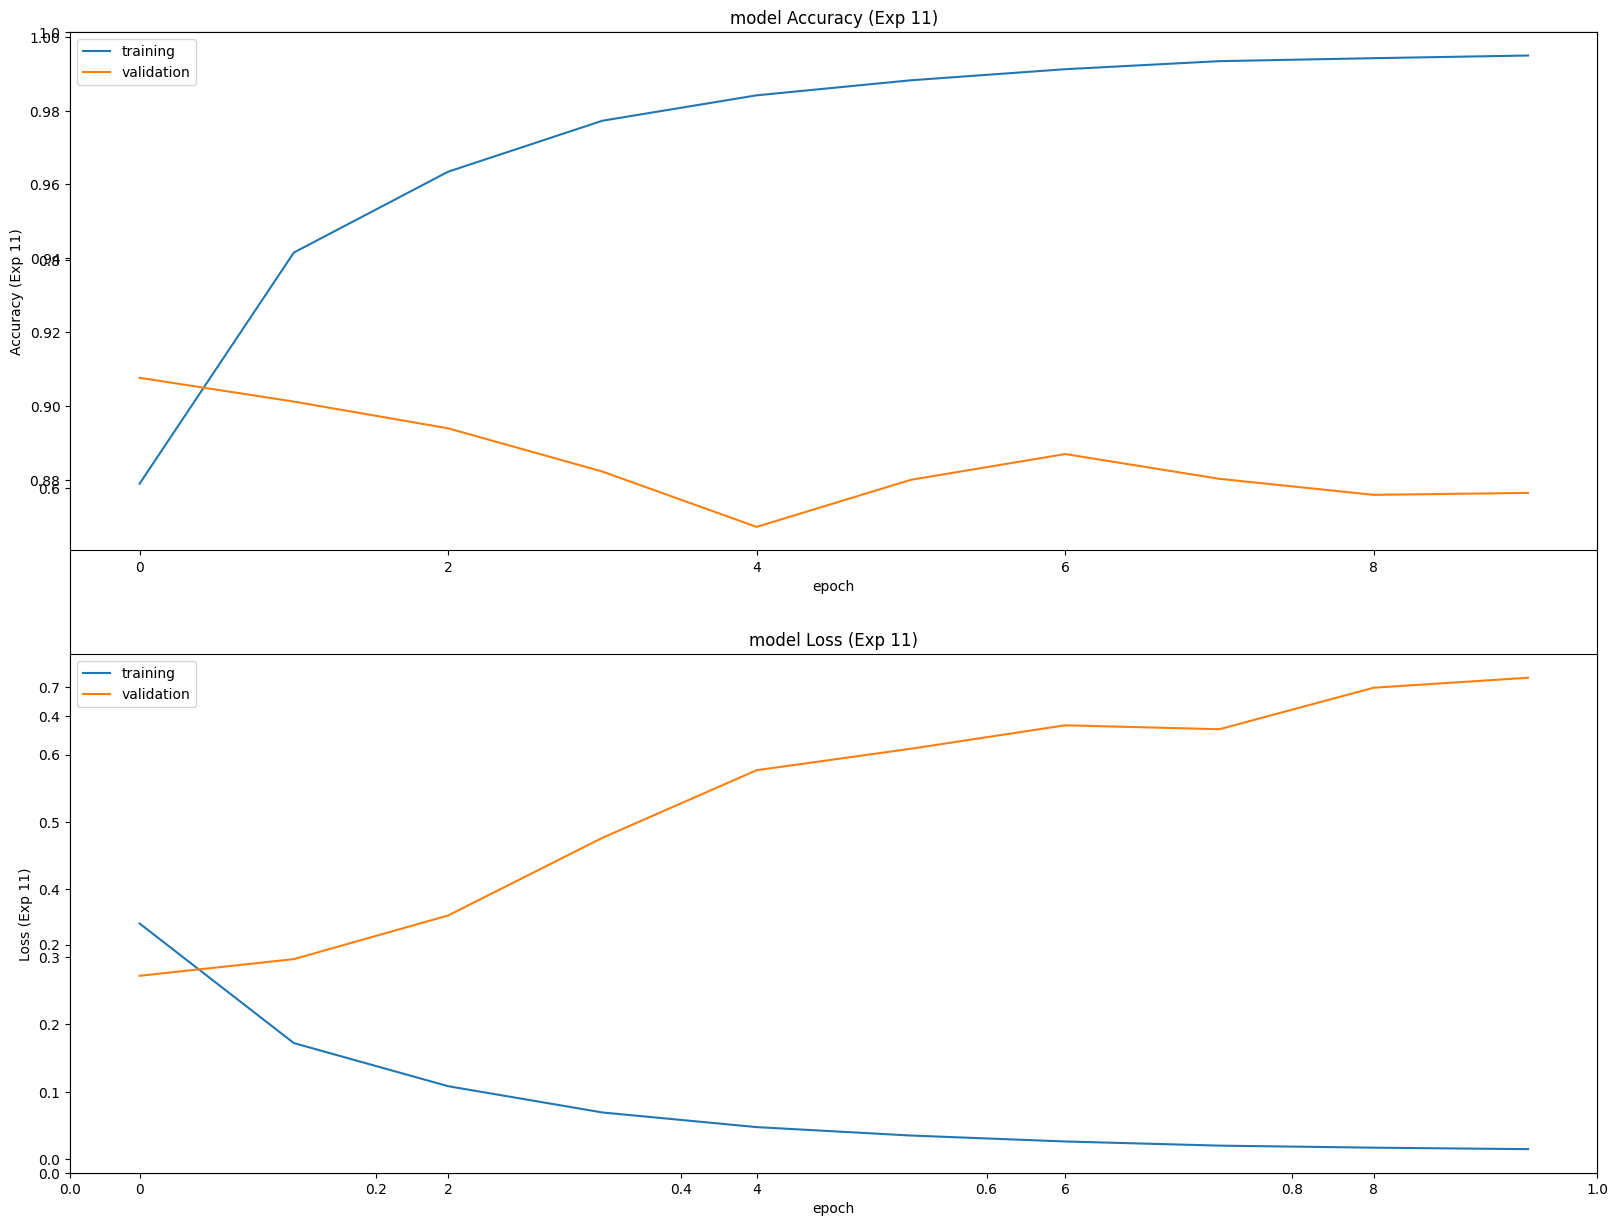

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1900
           1       0.95      0.94      0.95      1900
           2       0.84      0.82      0.83      1900
           3       0.85      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8764473684210526
Root Mean Square Error: 0.611942549763069


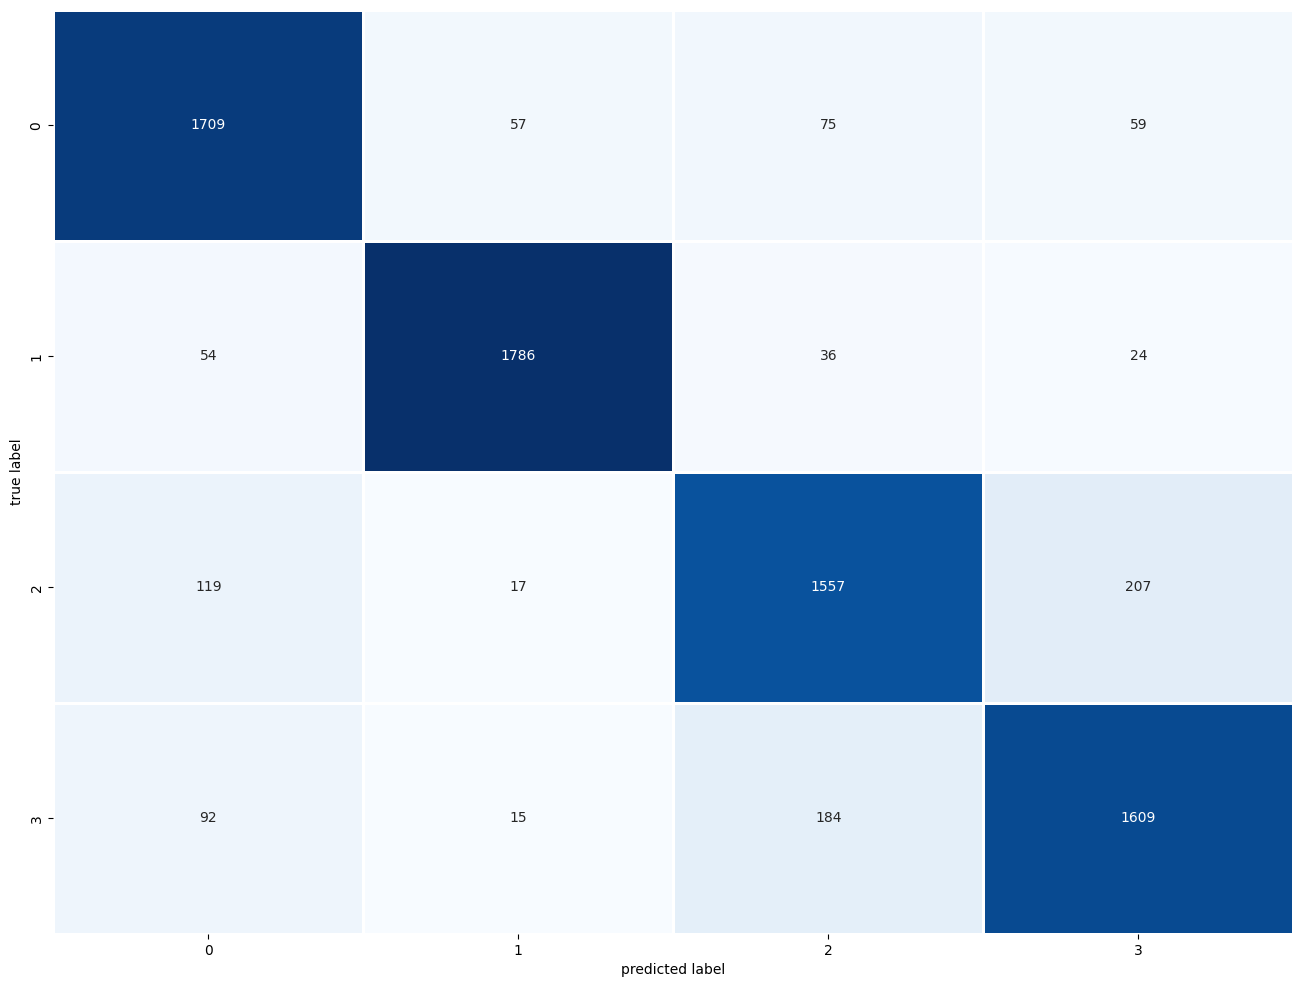

In [19]:
# ======================
# Experiment 11: GRU (Baseline - 128 units)
# ======================
model11 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.GRU(128),
    layers.Dense(n_classes, activation='softmax')
])

model11.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history11 = model11.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df11 = pd.DataFrame(history11.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df11['accuracy'], history_df11['val_accuracy'], 'Accuracy (Exp 11)', 211)
display_training_curves(history_df11['loss'], history_df11['val_loss'], 'Loss (Exp 11)', 212)
plt.show()

y_test11 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes11 = np.argmax(model11.predict(int_test_ds), axis=-1)
print_validation_report(y_test11, pred_classes11)
plot_confusion_matrix(y_test11, pred_classes11)

Experiment 12: GRU (Tweak - Bidirectional GRU)

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.8181 - loss: 0.4856 - val_accuracy: 0.9130 - val_loss: 0.2606
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9378 - loss: 0.1813 - val_accuracy: 0.9088 - val_loss: 0.2898
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9621 - loss: 0.1135 - val_accuracy: 0.8995 - val_loss: 0.3491
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9764 - loss: 0.0721 - val_accuracy: 0.8884 - val_loss: 0.4516
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9827 - loss: 0.0511 - val_accuracy: 0.8853 - val_loss: 0.5036
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9879 - loss: 0.0365 - val_accuracy: 0.8905 - val_loss: 0.5149
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9906 - loss: 0.0275 - val_accuracy: 0.8916 - val_loss: 0.5292
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9919 -

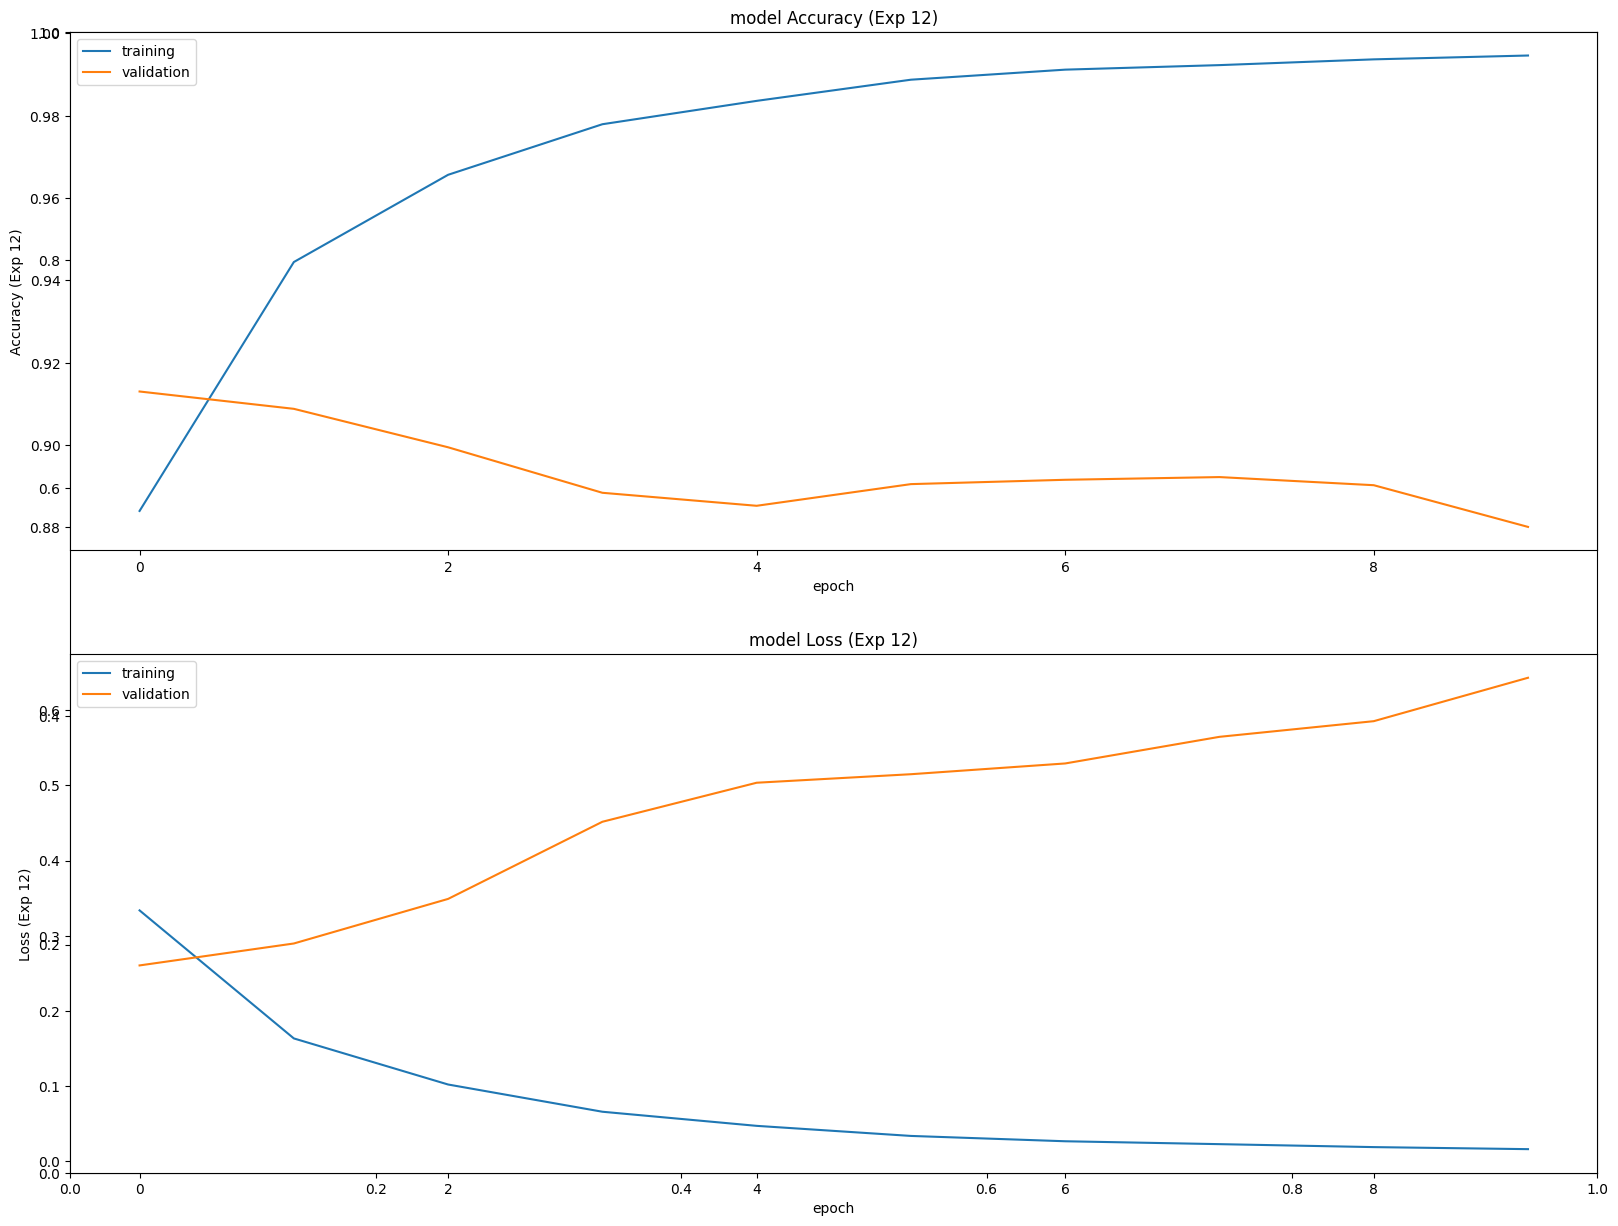

 1/76 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step

2025-08-01 13:47:24.929076: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1900
           1       0.96      0.95      0.95      1900
           2       0.87      0.79      0.83      1900
           3       0.83      0.87      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8801315789473684
Root Mean Square Error: 0.6098964536792506


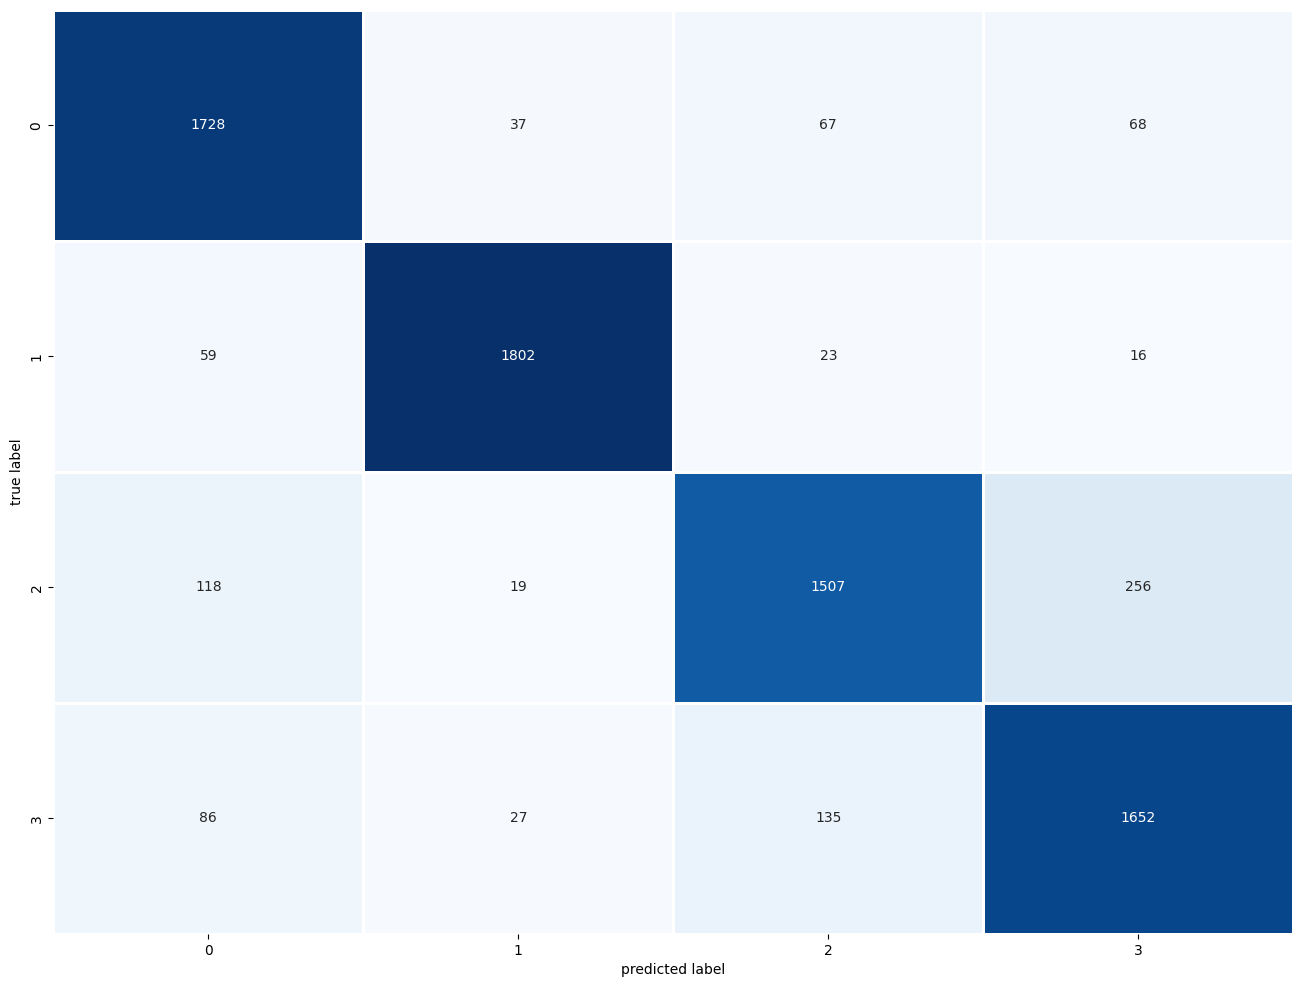

In [20]:
# ======================
# Experiment 12: GRU (Bidirectional - 128 units)
# ======================
model12 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Bidirectional(layers.GRU(128, dropout=0.3)),
    layers.Dense(n_classes, activation='softmax')
])

model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history12 = model12.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df12 = pd.DataFrame(history12.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df12['accuracy'], history_df12['val_accuracy'], 'Accuracy (Exp 12)', 211)
display_training_curves(history_df12['loss'], history_df12['val_loss'], 'Loss (Exp 12)', 212)
plt.show()

y_test12 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes12 = np.argmax(model12.predict(int_test_ds), axis=-1)
print_validation_report(y_test12, pred_classes12)
plot_confusion_matrix(y_test12, pred_classes12)

In [21]:
comparison_df = pd.DataFrame({
    "Experiment": [
        "Exp 2: RNN", "Exp 3: RNN (128 units)", "Exp 4: Stacked RNN", "Exp 5: Bi-RNN",
        "Exp 6: LSTM", "Exp 7: Stacked LSTM", "Exp 8: Bi-LSTM", "Exp 9: LSTM + Drop out",
        "Exp 10: 1D CNN", "Exp 11: GRU", "Exp 12: Bi-GRU"
    ],
    "Val Accuracy": [
        history_df2['val_accuracy'].iloc[-1],
        history_df3['val_accuracy'].iloc[-1],
        history_df4['val_accuracy'].iloc[-1],
        history_df5['val_accuracy'].iloc[-1],
        history_df6['val_accuracy'].iloc[-1],
        history_df7['val_accuracy'].iloc[-1],
        history_df8['val_accuracy'].iloc[-1],
        history_df9['val_accuracy'].iloc[-1],
        history_df10['val_accuracy'].iloc[-1],
        history_df11['val_accuracy'].iloc[-1],
        history_df12['val_accuracy'].iloc[-1],
    ]
})
print(comparison_df)

                Experiment  Val Accuracy
0               Exp 2: RNN      0.869474
1   Exp 3: RNN (128 units)      0.876579
2       Exp 4: Stacked RNN      0.881447
3            Exp 5: Bi-RNN      0.884474
4              Exp 6: LSTM      0.884474
5      Exp 7: Stacked LSTM      0.883553
6           Exp 8: Bi-LSTM      0.890526
7   Exp 9: LSTM + Drop out      0.873816
8           Exp 10: 1D CNN      0.891842
9              Exp 11: GRU      0.876447
10          Exp 12: Bi-GRU      0.880132


In [22]:
import time

# Example: store results for all experiments
results = []

# For each experiment, collect metrics
def record_results(exp_name, history_df, model, test_ds):
    start = time.time()
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    end = time.time()

    results.append({
        "Experiment": exp_name,
        "Train Accuracy": history_df['accuracy'].iloc[-1],
        "Val Accuracy": history_df['val_accuracy'].iloc[-1],
        "Train Loss": history_df['loss'].iloc[-1],
        "Val Loss": history_df['val_loss'].iloc[-1],
        "Test Accuracy": test_acc,
        "Test Loss": test_loss,
        "Process Time (s)": round(end - start, 2)
    })

# Example usage for each model
record_results("Exp 2: RNN", history_df2, model2, int_test_ds)
record_results("Exp 3: RNN (128 units)", history_df3, model3, int_test_ds)
record_results("Exp 4: Stacked RNN", history_df4, model4, int_test_ds)
record_results("Exp 5: Bi-RNN", history_df5, model5, int_test_ds)
record_results("Exp 6: LSTM", history_df6, model6, int_test_ds)
record_results("Exp 7: Stacked LSTM", history_df7, model7, int_test_ds)
record_results("Exp 8: Bi-LSTM", history_df8, model8, int_test_ds)
record_results("Exp 9: LSTM + Dropout", history_df9, model9, int_test_ds)
record_results("Exp 10: 1D CNN", history_df10, model10, int_test_ds)
record_results("Exp 11: GRU", history_df11, model11, int_test_ds)
record_results("Exp 12: Bi-GRU", history_df12, model12, int_test_ds)

# Convert to DataFrame
comparison_df = pd.DataFrame(results)
print(comparison_df)

                Experiment  Train Accuracy  Val Accuracy  Train Loss  \
0               Exp 2: RNN        0.994675      0.869474    0.016500   
1   Exp 3: RNN (128 units)        0.992808      0.876579    0.022619   
2       Exp 4: Stacked RNN        0.991025      0.881447    0.027638   
3            Exp 5: Bi-RNN        0.997125      0.884474    0.009620   
4              Exp 6: LSTM        0.994833      0.884474    0.013909   
5      Exp 7: Stacked LSTM        0.994750      0.883553    0.015818   
6           Exp 8: Bi-LSTM        0.996258      0.890526    0.011235   
7    Exp 9: LSTM + Dropout        0.993300      0.873816    0.019660   
8           Exp 10: 1D CNN        0.996342      0.891842    0.008907   
9              Exp 11: GRU        0.994933      0.876447    0.014924   
10          Exp 12: Bi-GRU        0.994642      0.880132    0.016248   

    Val Loss  Test Accuracy  Test Loss  Process Time (s)  
0   0.676223       0.869474   0.676223              2.43  
1   0.698371     

In [24]:
!jupyter nbconvert --to html MSDS458_A3_JKWOK_Final.ipynb

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.
